## Load Libraries, Load Data

In [1]:
import os
import sys
import numpy as np
from numpy.lib.arraysetops import unique
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import partial

from datetime import datetime
from pprint import pprint
from tqdm import tqdm
import ipdb
import pickle

plt.style.use("seaborn")
np.random.seed(1)

from training.utils import load_obj, save_obj
from training.data import load_data
from training.dataset import _preprocess_call_data, preprocess_and_make_dataset

from sklearn.cluster import KMeans, OPTICS, SpectralClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


from training.modelling.metrics import F1, Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from training.modelling.dataloader import get_train_val_test

beneficiary_data = pd.read_csv("feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv", sep='\t')
b_data, call_data = load_data("feb16-mar15_data")
call_data = _preprocess_call_data(call_data)
stats = pd.read_csv("feb16-mar15_data/weekly_kmeans_pilot_stats_40.csv")
all_beneficiaries = stats

features_dataset = preprocess_and_make_dataset(b_data, call_data)
# exit()

# beneficiary_splits = load_obj("may_data/RMAB_one_month/weekly_beneficiary_splits_single_group.pkl")

aug_states = []
for i in range(6):
    if i % 2 == 0:
        aug_states.append('L{}'.format(i // 2))
    else:
        aug_states.append('H{}'.format(i // 2))


f = partial(pd.to_datetime, dayfirst=True)


transitions = pd.read_csv("feb16-mar15_data/transitions.csv")
test_transitions = pd.read_csv('jan_data/transitions.csv')


2022-02-24 10:44:37,981 - INFO - load_data - Loading data from folder 'feb16-mar15_data'
2022-02-24 10:44:37,993 - INFO - load_call_data - Found 1 files in 'feb16-mar15_data/call'.
2022-02-24 10:44:37,994 - INFO - load_call_data - Loading and cleaning call data.
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:52<00:00, 412.73s/it]
2022-02-24 10:51:58,535 - WARNING - gest_age_to_list - 1 is not a valid gestation age.
2022-02-24 10:51:58,538 - WARNING - gest_age_to_list - 2 is not a valid gestation age.
2022-02-24 10:51:58,539 - WARNING - gest_age_to_list - 3 is not a valid gestation age.
2022-02-24 10:51:58,540 - WARNING - gest_age_to_list - 37 is not a valid gestation age.
2022-02-24 10:51:58,541 - WARNING - gest_age_to_list - 38 is not a valid gestation age.
2022-02-24 10:51:58,542 - WARNING - gest_age_to_list - 39 is not a valid gestation age.
2022-02-24 10:51:58,542 - WARNING - gest_age_to_list - 4 is not a valid gestation age.
202

2022-02-24 10:51:58,644 - WARNING - gest_age_to_list - 1 is not a valid gestation age.
2022-02-24 10:51:58,645 - WARNING - gest_age_to_list - 2 is not a valid gestation age.
2022-02-24 10:51:58,646 - WARNING - gest_age_to_list - 3 is not a valid gestation age.
2022-02-24 10:51:58,646 - WARNING - gest_age_to_list - 37 is not a valid gestation age.
2022-02-24 10:51:58,647 - WARNING - gest_age_to_list - 38 is not a valid gestation age.
2022-02-24 10:51:58,647 - WARNING - gest_age_to_list - 39 is not a valid gestation age.
2022-02-24 10:51:58,648 - WARNING - gest_age_to_list - 4 is not a valid gestation age.
2022-02-24 10:51:58,648 - WARNING - gest_age_to_list - 5 is not a valid gestation age.
2022-02-24 10:51:58,649 - WARNING - gest_age_to_list - 6 is not a valid gestation age.
2022-02-24 10:51:58,649 - WARNING - gest_age_to_list - 7 is not a valid gestation age.
2022-02-24 10:51:58,650 - WARNING - gest_age_to_list - introivr is not a valid gestation age.
2022-02-24 10:51:58,670 - WARNING

2022-02-24 10:51:59,167 - INFO - load_call_data - Call data contains 1234201 relevant call records for 23517 beneficiaries.
2022-02-24 10:51:59,199 - INFO - load_data - Successfully loaded and cleaned beneficiary and call data.
2022-02-24 10:51:59,200 - INFO - load_data - Beneficiary data contains data for 23517 beneficiaries
2022-02-24 10:51:59,211 - INFO - load_data - Call data contains 1234201 call records for 23517 beneficiaries
/Users/vermashresth/Documents/armman-clustering-mapping/Google-AI/mmitra-rmab/training/dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["duration"] = data["duration"].astype('uint8')
2022-02-24 10:52:09,342 - INFO - preprocess_and_make_dataset - Preprocessing beneficiary data.
2022-02-24 10:52:10,391

## Config File

In [182]:
CONFIG = {
    "problem": {
        "orig_states": ['L', 'H'],
        "states": aug_states + ['L', 'H'],
        "actions": ["N", "I"],
    },
    "time_step": 7,
    "gamma": 0.99,
    "clusters": 75, #int(sys.argv[1]),
    "transitions": "weekly",
    "clustering": 'kmeans', #sys.argv[2],
    "pilot_start_date": '2022-01-17', #sys.argv[3],
    #REVIEW: Adding New mapping config params
    "mapping_method": 'FO', # FO: Feature Only, WO: Warmup Only, FW: Feature+Warmup
    "train_warmup_start_date": '2021-03-01' , #REVIEW
    "test_warmup_start_date": '2021-11-01',
    "train_warmup_end_date": '2021-04-19', 
    "test_warmup_end_date":  '2021-12-20',
    'warmup_feat_cols': ['P(L, N, L)', 'P(H, N, L)']
}
n_clusters = 20

## Func Defs

In [24]:
def get_all_transition_probabilities(train_beneficiaries, transitions):
    cols = [
        "P(L, I, L)", "P(L, I, H)", "P(H, I, L)", "P(H, I, H)", "P(L, N, L)", "P(L, N, H)", "P(H, N, L)", "P(H, N, H)", 
    ]
    transition_probabilities = pd.DataFrame(columns = ['user_id'] + cols)
    transition_sup = pd.DataFrame(columns = ['user_id'] + cols)
    user_ids = train_beneficiaries['user_id']

    for user_id in tqdm(user_ids):
        probs, sup = get_transition_probabilities([user_id], transitions, min_support=1)
        probs['user_id'] = user_id
        sup['user_id'] = user_id
        transition_probabilities = transition_probabilities.append(probs, ignore_index=True)
        transition_sup = transition_sup.append(sup, ignore_index=True)

    return transition_probabilities, transition_sup

In [16]:

def kmeans_missing(X, n_clusters, max_iter=10):
    n_clusters = CONFIG['clusters']
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    prev_labels = None
    for i in range(max_iter):
        if CONFIG['clustering'] == 'optics':
            cls = OPTICS(min_samples=4, n_jobs=-1)
        elif CONFIG['clustering'] == 'kmeans':
            cls = KMeans(n_clusters, n_jobs=-1, random_state=0)
        elif CONFIG['clustering'] == 'spectral':
            cls = SpectralClustering(n_clusters, n_jobs=-1, random_state=0)

        labels = cls.fit_predict(X_hat)

        if CONFIG['clustering'] == 'kmeans':
            centroids = cls.cluster_centers_
        else:
            if CONFIG['clustering'] == 'optics':
                labels = labels + 1
            unique_labels = len(set(labels))
            centroids = []
            for i in range(unique_labels):
                idxes = np.where(labels == i)[0]
                centroids.append(np.mean(X_hat[idxes], axis=0))
            centroids = np.array(centroids)

        X_hat[missing] = centroids[labels][missing]

        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels

    return labels, centroids, X_hat, cls, len(set(labels)), i




def get_transition_probabilities(beneficiaries, transitions, min_support=3):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}

def get_all_transition_probabilities(train_beneficiaries, transitions):
    cols = [
        "P(L, I, L)", "P(L, I, H)", "P(H, I, L)", "P(H, I, H)", "P(L, N, L)", "P(L, N, H)", "P(H, N, L)", "P(H, N, H)", 
    ]
    transition_probabilities = pd.DataFrame(columns = ['user_id'] + cols)
    transition_sup = pd.DataFrame(columns = ['user_id'] + cols)
    user_ids = train_beneficiaries['user_id']

    for user_id in tqdm.tqdm(user_ids):
        probs, sup = get_transition_probabilities([user_id], transitions, min_support=1)
        probs['user_id'] = user_id
        sup['user_id'] = user_id
        transition_probabilities = transition_probabilities.append(probs, ignore_index=True)
        transition_sup = transition_sup.append(sup, ignore_index=True)

    return transition_probabilities, transition_sup


def get_reward(state, action, m):
    if state[0] == "L":
        reward = 1.0
    else:
        reward = -1.0
    if action == 'N':
        reward += m

    return reward


def plan(transition_probabilities, CONFIG):

    v_values = np.zeros((CONFIG['clusters'], len(CONFIG['problem']['states'])))
    q_values = np.zeros((CONFIG['clusters'], len(CONFIG['problem']['states']), len(CONFIG['problem']['actions'])))
    high_m_values = 1 * np.ones((CONFIG['clusters'], len(CONFIG['problem']['states'])))
    low_m_values = -1 * np.ones((CONFIG['clusters'], len(CONFIG['problem']['states'])))

    for cluster in range(CONFIG['clusters']):
        print('Planning for Cluster {}'.format(cluster))
        t_probs = np.zeros((len(CONFIG['problem']['states']), len(CONFIG['problem']['states']), len(CONFIG['problem']['actions'])))
        two_state_probs = np.zeros((2, 2, 2))
        for i in range(two_state_probs.shape[0]):
            for j in range(two_state_probs.shape[1]):
                for k in range(two_state_probs.shape[2]):
                    s = CONFIG['problem']['orig_states'][i]
                    s_prime = CONFIG['problem']['orig_states'][j]
                    a = CONFIG['problem']['actions'][k]
                    two_state_probs[i, j, k] = transition_probabilities.loc[transition_probabilities['cluster']==cluster, "P(" + s + ", " + a + ", " + s_prime + ")"]
        
        t_probs[0 : 2, 2 : 4, 0] = two_state_probs[:, :, 0]
        t_probs[2 : 4, 4 : 6, 0] = two_state_probs[:, :, 0]
        t_probs[4 : 6, 6 : 8, 0] = two_state_probs[:, :, 0]
        t_probs[6 : 8, 6 : 8, 0] = two_state_probs[:, :, 0]

        t_probs[0 : 2, 2 : 4, 1] = two_state_probs[:, :, 0]
        t_probs[2 : 4, 4 : 6, 1] = two_state_probs[:, :, 0]
        t_probs[4 : 6, 6 : 8, 1] = two_state_probs[:, :, 0]
        t_probs[6 : 8, 0 : 2, 1] = two_state_probs[:, :, 1]

        ipdb.set_trace()

        max_q_diff = np.inf
        prev_m_values, m_values = None, None
        while max_q_diff > 1e-5:
            prev_m_values = m_values
            m_values = (low_m_values + high_m_values) / 2
            if type(prev_m_values) != type(None) and abs(prev_m_values - m_values).max() < 1e-20:
                break
            max_q_diff = 0
            v_values[cluster, :] = np.zeros((len(CONFIG['problem']['states'])))
            q_values[cluster, :, :] = np.zeros((len(CONFIG['problem']['states']), len(CONFIG['problem']['actions'])))
            delta = np.inf
            while delta > 0.0001:
                delta = 0
                for i in range(t_probs.shape[0]):
                    v = v_values[cluster, i]
                    v_a = np.zeros((t_probs.shape[2],))
                    for k in range(v_a.shape[0]):
                        for j in range(t_probs.shape[1]):
                            v_a[k] += t_probs[i, j, k] * (get_reward(CONFIG['problem']['states'][i], CONFIG['problem']['actions'][k], m_values[cluster, i]) + CONFIG["gamma"] * v_values[cluster, j])

                    v_values[cluster, i] = np.max(v_a)
                    delta = max([delta, abs(v_values[cluster, i] - v)])

            state_idx = -1
            for state in range(q_values.shape[1]):
                for action in range(q_values.shape[2]):
                    for next_state in range(q_values.shape[1]):
                        q_values[cluster, state, action] += t_probs[state, next_state, action] * (get_reward(CONFIG['problem']['states'][state], CONFIG['problem']['actions'][action], m_values[cluster, state]) + CONFIG["gamma"] * v_values[cluster, next_state])
                # print(state, q_values[cluster, state, 0], q_values[cluster, state, 1])

            for state in range(q_values.shape[1]):
                if abs(q_values[cluster, state, 1] - q_values[cluster, state, 0]) > max_q_diff:
                    state_idx = state
                    max_q_diff = abs(q_values[cluster, state, 1] - q_values[cluster, state, 0])

            # print(q_values)
            # print(low_m_values, high_m_values)
            if max_q_diff > 1e-5 and q_values[cluster, state_idx, 0] < q_values[cluster, state_idx, 1]:
                low_m_values[cluster, state_idx] = m_values[cluster, state_idx]
            elif max_q_diff > 1e-5 and q_values[cluster, state_idx, 0] > q_values[cluster, state_idx, 1]:
                high_m_values[cluster, state_idx] = m_values[cluster, state_idx]

            # print(low_m_values, high_m_values, state_idx)
            # ipdb.set_trace()
    
    m_values = (low_m_values + high_m_values) / 2

    return q_values, m_values


2022-02-24 11:36:08,220 - INFO - load_data - Loading data from folder 'jan_data'
2022-02-24 11:36:08,224 - INFO - load_beneficiary_data - Found 1 files in 'jan_data/beneficiary'.
2022-02-24 11:36:08,225 - INFO - load_beneficiary_data - Loading and cleaning beneficiary data.


2022-02-24 11:36:37,533 - INFO - load_beneficiary_data - Beneficiary data contains data for 53139 beneficiaries.
2022-02-24 11:36:37,536 - INFO - load_call_data - Found 1 files in 'jan_data/call'.
2022-02-24 11:36:37,536 - INFO - load_call_data - Loading and cleaning call data.

  0%|                                                                                              | 0/1 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:55<00:00, 355.23s/it]


Shape of call data (0): (15471754, 6)
          user_id        startdatetime  duration  gest_age        dropreason  \
0         2459276  2021-10-01 08:31:12         7        37   NORMAL_CLEARING   
1         2505157  2021-10-01 08:31:14         1        25   NORMAL_CLEARING   
2         2499772  2021-10-01 08:31:15        18        25   NORMAL_CLEARING   
3         2468364  2021-10-01 08:31:15       138        31   NORMAL_CLEARING   
4         2460529  2021-10-01 08:31:20       138        31   NORMAL_CLEARING   
...           ...                  ...       ...       ...               ...   
15471749  2669382  2022-02-20 20:05:11        18         6   NORMAL_CLEARING   
15471750  2752085  2022-02-20 20:05:12         0         9  NO_USER_RESPONSE   
15471751  2507213  2022-02-20 20:05:14         0         1  NO_USER_RESPONSE   
15471752  2721323  2022-02-20 20:05:44         0         7  NO_USER_RESPONSE   
15471753  2680669  2022-02-20 20:06:34         0         7  NO_USER_RESPONSE   

 

2022-02-24 11:42:51,007 - INFO - load_call_data - Call data contains 751891 relevant call records for 52862 beneficiaries.


Shape of call data (4): (751891, 6)
Shape of call data at end of merge call files function (5): (751891, 6)


2022-02-24 11:42:51,043 - INFO - load_data - Successfully loaded and cleaned beneficiary and call data.
2022-02-24 11:42:51,043 - INFO - load_data - Beneficiary data contains data for 52862 beneficiaries
2022-02-24 11:42:51,054 - INFO - load_data - Call data contains 751891 call records for 52862 beneficiaries
2022-02-24 11:42:51,059 - INFO - preprocess_and_make_dataset - Preprocessing beneficiary data.
2022-02-24 11:42:59,185 - INFO - preprocess_and_make_dataset - Preprocessing beneficiary data completed.
2022-02-24 11:42:59,186 - INFO - preprocess_and_make_dataset - Preprocessed beneficiary data shape: (52862, 45)
2022-02-24 11:42:59,186 - INFO - preprocess_and_make_dataset - Preprocessing call data.


enroll_gest_age
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43}
129      0
688      0
841      0
845      0
854      0
        ..
50202    0
51205    0
52457    0
52585    0
52759    0
Name: enroll_gest_age, Length: 632, dtype: int64
(632,)
age
{15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50, 55}
26572    55
Name: age, dtype: int64
(1,)
g
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20}
384      11
1404      6
2548      6
2669      6
2947      6
         ..
47908     6
50023     7
50748     8
50892     7
53112     6
Name: g, Length: 88, dtype: int64
(88,)
p
{0, 1, 2, 3, 4, 5, 6, 7, 8}
6620     6
10922    7
13742    6
15368    6
21932    6
22601    7
27596    6
28284    6
28702    8
43646    8
45642    8
50023    6
50892    7
Name: p, dtype: int64
(13,)
s
{0, 1, 2, 3, 4, 5, 6}
498      2
1287     2
1

2022-02-24 11:42:59,385 - INFO - preprocess_and_make_dataset - Preprocessing call data completed.
2022-02-24 11:42:59,385 - INFO - preprocess_and_make_dataset - Preprocessed call data shape: (751891, 6)
2022-02-24 11:42:59,386 - INFO - preprocess_and_make_dataset - Building the dataset.
2022-02-24 11:42:59,448 - INFO - preprocess_and_make_dataset - Preproccessed data has 52862 beneficiaries and 751891 calls.
2022-02-24 11:42:59,449 - INFO - _build_dataset - 52862 beneficiaries in beneficiary data.


(751891, 6)



  0%|▎                                                                                 | 15/4406 [00:00<03:14, 22.56it/s]


  1%|▌                                                                                 | 31/4405 [00:01<03:10, 22.92it/s]


  1%|▊                                                                                 | 46/4405 [00:02<03:06, 23.33it/s]


  1%|█▏                                                                                | 62/4405 [00:02<03:07, 23.11it/s]


  2%|█▍                                                                                | 78/4405 [00:03<03:08, 22.99it/s]


  2%|█▊                                                                                | 95/4405 [00:04<03:03, 23.46it/s]


  3%|██                                                                               | 111/4405 [00:04<03:09, 22.66it/s]


  3%|██▎                                                                              | 128/4405 [00:05<03:08, 22.70it/s]


  3%|██▋                                                                              | 143/4405 [00:06<03:04, 23.07it/s]


  4%|██▉                                                                              | 162/4406 [00:07<03:14, 21.85it/s]


  4%|███▏                                                                             | 175/4405 [00:07<03:08, 22.48it/s]


  4%|███▌                                                                             | 192/4405 [00:08<03:00, 23.30it/s]


  5%|███▊                                                                             | 209/4405 [00:09<02:58, 23.45it/s]


  5%|████▏                                                                            | 225/4405 [00:09<03:03, 22.79it/s]


  5%|████▍                                                                            | 240/4405 [00:10<03:06, 22.30it/s]


  6%|████▋                                                                            | 257/4405 [00:11<03:01, 22.90it/s]


  6%|█████                                                                            | 274/4405 [00:12<02:59, 23.04it/s]


  7%|█████▎                                                                           | 290/4405 [00:12<03:19, 20.58it/s]


  7%|█████▋                                                                           | 306/4405 [00:13<03:02, 22.44it/s]


  7%|█████▉                                                                           | 322/4405 [00:14<03:01, 22.45it/s]


  8%|██████▏                                                                          | 338/4405 [00:14<03:06, 21.75it/s]


  8%|██████▌                                                                          | 354/4405 [00:15<02:54, 23.23it/s]


  8%|██████▊                                                                          | 370/4405 [00:16<03:02, 22.11it/s]


  9%|███████▏                                                                         | 390/4406 [00:17<02:55, 22.89it/s]


  9%|███████▍                                                                         | 403/4405 [00:17<02:54, 22.88it/s]


 10%|███████▋                                                                         | 420/4405 [00:18<02:53, 23.01it/s]


 10%|████████                                                                         | 436/4405 [00:19<02:55, 22.65it/s]


 10%|████████▎                                                                        | 452/4405 [00:19<02:53, 22.80it/s]


 11%|████████▌                                                                        | 469/4405 [00:20<02:52, 22.84it/s]


 11%|████████▉                                                                        | 485/4405 [00:21<02:50, 22.96it/s]


 11%|█████████▏                                                                       | 501/4405 [00:22<02:49, 23.08it/s]


 12%|█████████▌                                                                       | 517/4405 [00:22<02:48, 23.08it/s]


 12%|█████████▊                                                                       | 533/4405 [00:23<03:22, 19.15it/s]


 12%|██████████                                                                       | 547/4405 [00:24<03:09, 20.41it/s]


 13%|██████████▎                                                                      | 563/4405 [00:24<02:49, 22.62it/s]


 13%|██████████▋                                                                      | 579/4405 [00:25<02:46, 23.03it/s]


 14%|██████████▉                                                                      | 596/4405 [00:26<02:43, 23.24it/s]


 14%|███████████▏                                                                     | 611/4405 [00:27<02:45, 22.89it/s]


 14%|███████████▌                                                                     | 628/4405 [00:27<02:43, 23.12it/s]


 15%|███████████▉                                                                     | 647/4406 [00:28<02:39, 23.55it/s]


 15%|████████████▏                                                                    | 663/4406 [00:29<02:45, 22.64it/s]


 15%|████████████▍                                                                    | 676/4405 [00:29<02:44, 22.67it/s]


 16%|████████████▊                                                                    | 696/4406 [00:30<02:41, 22.95it/s]


 16%|█████████████                                                                    | 709/4405 [00:31<02:37, 23.42it/s]


 16%|█████████████▎                                                                   | 726/4405 [00:32<02:53, 21.18it/s]


 17%|█████████████▋                                                                   | 742/4405 [00:33<02:33, 23.94it/s]


 17%|█████████████▉                                                                   | 759/4405 [00:33<02:38, 22.96it/s]


 18%|██████████████▏                                                                  | 774/4405 [00:34<02:44, 22.06it/s]


 18%|██████████████▌                                                                  | 792/4405 [00:35<02:50, 21.15it/s]


 18%|██████████████▊                                                                  | 808/4405 [00:35<02:49, 21.26it/s]


 19%|███████████████▏                                                                 | 825/4405 [00:36<02:38, 22.58it/s]


 19%|███████████████▍                                                                 | 841/4405 [00:37<02:46, 21.45it/s]


 20%|███████████████▊                                                                 | 862/4406 [00:38<02:22, 24.86it/s]


 20%|████████████████                                                                 | 873/4405 [00:38<02:37, 22.49it/s]


 20%|████████████████▍                                                                | 895/4406 [00:39<02:43, 21.44it/s]


 21%|████████████████▋                                                                | 905/4405 [00:40<02:30, 23.22it/s]


 21%|████████████████▉                                                                | 921/4405 [00:41<02:29, 23.27it/s]


 21%|█████████████████▎                                                               | 939/4405 [00:41<02:32, 22.78it/s]


 22%|█████████████████▌                                                               | 954/4405 [00:42<02:30, 22.97it/s]


 22%|█████████████████▊                                                               | 967/4405 [00:43<02:38, 21.75it/s]


 22%|██████████████████▏                                                              | 988/4405 [00:43<02:32, 22.35it/s]


 23%|██████████████████▏                                                             | 1003/4405 [00:44<02:13, 25.48it/s]


 23%|██████████████████▌                                                             | 1024/4405 [00:45<02:24, 23.33it/s]


 23%|██████████████████▊                                                             | 1035/4405 [00:46<02:39, 21.11it/s]


 24%|███████████████████▏                                                            | 1058/4405 [00:46<02:07, 26.25it/s]


 24%|███████████████████▍                                                            | 1069/4405 [00:47<02:22, 23.47it/s]


 25%|███████████████████▋                                                            | 1086/4405 [00:48<02:20, 23.60it/s]


 25%|████████████████████                                                            | 1106/4405 [00:49<02:36, 21.02it/s]


 25%|████████████████████▎                                                           | 1117/4405 [00:49<02:19, 23.56it/s]


 26%|████████████████████▋                                                           | 1139/4405 [00:50<02:20, 23.17it/s]


 26%|████████████████████▉                                                           | 1150/4405 [00:51<02:37, 20.62it/s]


 27%|█████████████████████▎                                                          | 1172/4406 [00:52<02:20, 23.10it/s]


 27%|█████████████████████▋                                                          | 1191/4406 [00:52<02:23, 22.46it/s]


 27%|█████████████████████▉                                                          | 1205/4405 [00:53<02:26, 21.82it/s]


 28%|██████████████████████                                                          | 1216/4405 [00:54<02:17, 23.13it/s]


 28%|██████████████████████▍                                                         | 1238/4406 [00:54<02:16, 23.17it/s]


 28%|██████████████████████▋                                                         | 1249/4405 [00:55<02:22, 22.21it/s]


 29%|██████████████████████▉                                                         | 1266/4405 [00:56<02:14, 23.37it/s]


 29%|███████████████████████▎                                                        | 1286/4406 [00:57<02:19, 22.44it/s]


 29%|███████████████████████▌                                                        | 1299/4405 [00:57<02:17, 22.65it/s]


 30%|███████████████████████▉                                                        | 1319/4405 [00:58<02:27, 20.87it/s]


 30%|████████████████████████▎                                                       | 1336/4405 [00:59<02:27, 20.75it/s]


 31%|████████████████████████▍                                                       | 1346/4405 [01:00<02:35, 19.63it/s]


 31%|████████████████████████▋                                                       | 1362/4405 [01:00<02:20, 21.66it/s]


 31%|████████████████████████▉                                                       | 1374/4405 [01:01<02:21, 21.50it/s]


 32%|█████████████████████████▍                                                      | 1399/4406 [01:02<02:22, 21.12it/s]


 32%|█████████████████████████▋                                                      | 1412/4405 [01:03<02:30, 19.91it/s]


 32%|█████████████████████████▉                                                      | 1425/4405 [01:03<02:18, 21.47it/s]


 33%|██████████████████████████▎                                                     | 1447/4406 [01:04<02:16, 21.61it/s]


 33%|██████████████████████████▍                                                     | 1458/4405 [01:05<02:52, 17.08it/s]


 33%|██████████████████████████▊                                                     | 1473/4405 [01:06<02:30, 19.54it/s]


 34%|███████████████████████████                                                     | 1491/4405 [01:06<02:10, 22.31it/s]


 34%|███████████████████████████▎                                                    | 1506/4405 [01:07<02:06, 22.92it/s]


 35%|███████████████████████████▋                                                    | 1522/4405 [01:08<02:21, 20.34it/s]


 35%|███████████████████████████▊                                                    | 1533/4405 [01:09<02:01, 23.56it/s]


 35%|████████████████████████████▎                                                   | 1557/4405 [01:09<02:04, 22.88it/s]


 36%|████████████████████████████▌                                                   | 1572/4405 [01:10<02:20, 20.15it/s]


 36%|████████████████████████████▉                                                   | 1590/4405 [01:11<01:57, 23.95it/s]


 36%|█████████████████████████████                                                   | 1601/4405 [01:12<02:05, 22.32it/s]


 37%|█████████████████████████████▍                                                  | 1621/4405 [01:12<02:21, 19.64it/s]


 37%|█████████████████████████████▋                                                  | 1633/4405 [01:13<02:07, 21.69it/s]


 38%|██████████████████████████████                                                  | 1653/4405 [01:14<02:04, 22.13it/s]


 38%|██████████████████████████████▎                                                 | 1672/4405 [01:15<02:03, 22.05it/s]


 38%|██████████████████████████████▊                                                 | 1695/4405 [01:15<01:53, 23.82it/s]


 39%|███████████████████████████████                                                 | 1707/4405 [01:16<01:55, 23.43it/s]


 39%|███████████████████████████████▏                                                | 1718/4405 [01:17<02:07, 21.06it/s]


 39%|███████████████████████████████▌                                                | 1735/4405 [01:18<01:38, 27.19it/s]


 40%|███████████████████████████████▋                                                | 1748/4405 [01:18<02:01, 21.85it/s]


 40%|████████████████████████████████                                                | 1766/4405 [01:19<02:00, 21.95it/s]


 40%|████████████████████████████████▎                                               | 1781/4405 [01:20<02:02, 21.37it/s]


 41%|████████████████████████████████▋                                               | 1800/4405 [01:20<01:54, 22.78it/s]


 41%|█████████████████████████████████                                               | 1822/4406 [01:21<01:55, 22.32it/s]


 42%|█████████████████████████████████▏                                              | 1829/4405 [01:22<02:04, 20.74it/s]


 42%|█████████████████████████████████▋                                              | 1853/4405 [01:23<01:53, 22.47it/s]


 42%|█████████████████████████████████▉                                              | 1869/4405 [01:23<01:53, 22.36it/s]


 43%|██████████████████████████████████▏                                             | 1882/4405 [01:24<01:57, 21.44it/s]


 43%|██████████████████████████████████▌                                             | 1903/4406 [01:25<01:49, 22.90it/s]


 43%|██████████████████████████████████▊                                             | 1915/4405 [01:26<01:47, 23.25it/s]


 44%|███████████████████████████████████                                             | 1933/4405 [01:26<01:55, 21.44it/s]


 44%|███████████████████████████████████▍                                            | 1952/4405 [01:27<01:48, 22.52it/s]


 45%|███████████████████████████████████▊                                            | 1974/4405 [01:28<01:48, 22.45it/s]


 45%|████████████████████████████████████                                            | 1985/4405 [01:29<01:49, 22.05it/s]


 45%|████████████████████████████████████▎                                           | 2000/4405 [01:29<01:45, 22.81it/s]


 46%|████████████████████████████████████▌                                           | 2017/4406 [01:30<01:57, 20.27it/s]


 46%|████████████████████████████████████▉                                           | 2031/4405 [01:31<01:46, 22.21it/s]


 47%|█████████████████████████████████████▏                                          | 2050/4406 [01:32<01:42, 23.09it/s]


 47%|█████████████████████████████████████▍                                          | 2063/4405 [01:32<01:40, 23.35it/s]


 47%|█████████████████████████████████████▊                                          | 2083/4406 [01:33<01:45, 22.00it/s]


 47%|█████████████████████████████████████▉                                          | 2090/4405 [01:34<01:51, 20.76it/s]


 48%|██████████████████████████████████████▌                                         | 2122/4405 [01:34<01:38, 23.22it/s]


 48%|██████████████████████████████████████▌                                         | 2123/4405 [01:35<01:39, 22.94it/s]


 49%|██████████████████████████████████████▉                                         | 2145/4405 [01:36<01:49, 20.57it/s]


 49%|███████████████████████████████████████▎                                        | 2168/4405 [01:37<01:36, 23.09it/s]


 49%|███████████████████████████████████████▌                                        | 2180/4405 [01:37<01:39, 22.39it/s]


 50%|███████████████████████████████████████▊                                        | 2189/4405 [01:38<01:40, 22.06it/s]


 50%|████████████████████████████████████████▏                                       | 2214/4405 [01:39<01:35, 22.94it/s]


 51%|████████████████████████████████████████▌                                       | 2234/4405 [01:40<01:32, 23.59it/s]


 51%|████████████████████████████████████████▊                                       | 2249/4405 [01:40<01:39, 21.68it/s]


 51%|█████████████████████████████████████████                                       | 2259/4405 [01:41<01:33, 23.00it/s]


 52%|█████████████████████████████████████████▍                                      | 2282/4405 [01:42<01:33, 22.72it/s]


 52%|█████████████████████████████████████████▊                                      | 2299/4405 [01:42<01:38, 21.28it/s]


 52%|█████████████████████████████████████████▉                                      | 2306/4405 [01:43<01:30, 23.23it/s]


 53%|██████████████████████████████████████████▎                                     | 2333/4405 [01:44<01:32, 22.40it/s]


 53%|██████████████████████████████████████████▋                                     | 2349/4406 [01:45<01:30, 22.80it/s]


 54%|██████████████████████████████████████████▉                                     | 2361/4405 [01:45<01:27, 23.41it/s]


 54%|███████████████████████████████████████████                                     | 2373/4405 [01:46<01:32, 21.89it/s]


 54%|███████████████████████████████████████████▌                                    | 2397/4405 [01:47<01:35, 20.92it/s]


 54%|███████████████████████████████████████████▌                                    | 2399/4405 [01:48<01:26, 23.31it/s]


 55%|████████████████████████████████████████████▏                                   | 2433/4405 [01:48<01:26, 22.87it/s]


 55%|████████████████████████████████████████████▎                                   | 2440/4405 [01:49<01:25, 22.97it/s]


 56%|████████████████████████████████████████████▋                                   | 2463/4406 [01:50<01:17, 24.92it/s]


 56%|█████████████████████████████████████████████                                   | 2478/4405 [01:51<01:28, 21.68it/s]


 56%|█████████████████████████████████████████████▏                                  | 2485/4405 [01:51<01:29, 21.50it/s]


 57%|█████████████████████████████████████████████▋                                  | 2515/4405 [01:52<01:32, 20.38it/s]


 57%|█████████████████████████████████████████████▊                                  | 2526/4406 [01:53<01:21, 23.12it/s]


 58%|██████████████████████████████████████████████▎                                 | 2550/4405 [01:53<01:19, 23.35it/s]


 58%|██████████████████████████████████████████████▎                                 | 2552/4405 [01:54<01:29, 20.60it/s]


 58%|██████████████████████████████████████████████▌                                 | 2564/4405 [01:55<01:22, 22.36it/s]


 59%|██████████████████████████████████████████████▉                                 | 2585/4405 [01:56<01:25, 21.31it/s]


 59%|███████████████████████████████████████████████▍                                | 2610/4405 [01:56<01:30, 19.88it/s]


 60%|███████████████████████████████████████████████▌                                | 2621/4405 [01:57<01:16, 23.24it/s]


 60%|████████████████████████████████████████████████                                | 2643/4405 [01:58<01:18, 22.38it/s]


 60%|████████████████████████████████████████████████▎                               | 2662/4405 [01:59<01:18, 22.17it/s]


 61%|████████████████████████████████████████████████▌                               | 2673/4405 [01:59<01:15, 22.93it/s]


 61%|████████████████████████████████████████████████▋                               | 2681/4405 [02:00<01:19, 21.63it/s]


 62%|█████████████████████████████████████████████████▎                              | 2714/4406 [02:01<01:16, 22.03it/s]


 62%|█████████████████████████████████████████████████▎                              | 2716/4405 [02:01<01:14, 22.62it/s]


 62%|█████████████████████████████████████████████████▋                              | 2739/4405 [02:02<01:15, 21.96it/s]


 62%|█████████████████████████████████████████████████▉                              | 2748/4405 [02:03<01:21, 20.25it/s]


 63%|██████████████████████████████████████████████████▏                             | 2766/4405 [02:04<01:09, 23.54it/s]


 63%|██████████████████████████████████████████████████▌                             | 2782/4405 [02:04<01:14, 21.84it/s]


 64%|██████████████████████████████████████████████████▊                             | 2799/4405 [02:05<01:11, 22.39it/s]


 64%|███████████████████████████████████████████████████▏                            | 2820/4405 [02:06<01:08, 23.25it/s]


 64%|███████████████████████████████████████████████████▍                            | 2832/4405 [02:07<01:09, 22.75it/s]


 65%|███████████████████████████████████████████████████▊                            | 2853/4405 [02:07<01:11, 21.84it/s]


 66%|████████████████████████████████████████████████████▍                           | 2888/4405 [02:08<01:02, 24.30it/s]


 65%|████████████████████████████████████████████████████▎                           | 2883/4405 [02:09<01:06, 22.72it/s]


 66%|████████████████████████████████████████████████████▋                           | 2904/4406 [02:10<01:08, 21.91it/s]


 67%|█████████████████████████████████████████████████████▏                          | 2931/4406 [02:10<00:55, 26.65it/s]


 67%|█████████████████████████████████████████████████████▋                          | 2954/4405 [02:11<01:04, 22.36it/s]


 67%|█████████████████████████████████████████████████████▊                          | 2964/4406 [02:12<01:10, 20.49it/s]


 67%|█████████████████████████████████████████████████████▊                          | 2960/4405 [02:13<01:14, 19.28it/s]


 68%|██████████████████████████████████████████████████████▌                         | 3002/4405 [02:14<01:16, 18.38it/s]


 68%|██████████████████████████████████████████████████████▌                         | 3001/4405 [02:14<01:09, 20.16it/s]


 69%|██████████████████████████████████████████████████████▉                         | 3022/4405 [02:15<01:07, 20.51it/s]


 69%|███████████████████████████████████████████████████████                         | 3035/4405 [02:16<00:53, 25.77it/s]


 70%|███████████████████████████████████████████████████████▋                        | 3066/4405 [02:17<01:01, 21.77it/s]


 69%|███████████████████████████████████████████████████████▍                        | 3055/4405 [02:17<01:01, 21.96it/s]


 70%|███████████████████████████████████████████████████████▉                        | 3084/4406 [02:18<01:07, 19.71it/s]


 70%|████████████████████████████████████████████████████████▎                       | 3102/4405 [02:19<00:56, 23.21it/s]


 71%|████████████████████████████████████████████████████████▍                       | 3110/4405 [02:19<00:57, 22.54it/s]


 71%|████████████████████████████████████████████████████████▋                       | 3124/4405 [02:20<01:00, 21.33it/s]


 71%|█████████████████████████████████████████████████████████▏                      | 3149/4405 [02:21<00:59, 21.02it/s]


 72%|█████████████████████████████████████████████████████████▌                      | 3168/4405 [02:22<00:54, 22.55it/s]


 72%|█████████████████████████████████████████████████████████▌                      | 3169/4405 [02:22<00:58, 21.21it/s]


 73%|██████████████████████████████████████████████████████████▏                     | 3201/4405 [02:23<00:53, 22.38it/s]


 73%|██████████████████████████████████████████████████████████▋                     | 3232/4405 [02:24<00:51, 22.67it/s]


 73%|██████████████████████████████████████████████████████████▌                     | 3227/4405 [02:25<00:55, 21.05it/s]


 74%|███████████████████████████████████████████████████████████                     | 3249/4405 [02:25<00:48, 23.61it/s]


 74%|███████████████████████████████████████████████████████████▏                    | 3260/4405 [02:26<00:49, 23.22it/s]


 75%|███████████████████████████████████████████████████████████▌                    | 3282/4405 [02:27<00:53, 21.11it/s]


 75%|███████████████████████████████████████████████████████████▊                    | 3290/4405 [02:28<00:40, 27.40it/s]


 75%|████████████████████████████████████████████████████████████▏                   | 3315/4405 [02:28<00:46, 23.29it/s]


 75%|████████████████████████████████████████████████████████████▎                   | 3318/4405 [02:29<00:48, 22.54it/s]


 76%|████████████████████████████████████████████████████████████▊                   | 3348/4405 [02:30<00:51, 20.33it/s]


 76%|████████████████████████████████████████████████████████████▉                   | 3358/4405 [02:31<00:47, 21.89it/s]


 77%|█████████████████████████████████████████████████████████████▍                  | 3384/4405 [02:31<00:44, 22.85it/s]


 77%|█████████████████████████████████████████████████████████████▋                  | 3399/4406 [02:32<00:48, 20.82it/s]


 78%|██████████████████████████████████████████████████████████████▎                 | 3428/4405 [02:33<00:41, 23.32it/s]


 78%|██████████████████████████████████████████████████████████████▎                 | 3432/4406 [02:34<00:43, 22.18it/s]


 78%|██████████████████████████████████████████████████████████████▌                 | 3448/4405 [02:34<00:44, 21.70it/s]


 79%|██████████████████████████████████████████████████████████████▉                 | 3463/4405 [02:35<00:39, 24.03it/s]


 79%|███████████████████████████████████████████████████████████████▏                | 3476/4405 [02:36<00:50, 18.25it/s]


 79%|███████████████████████████████████████████████████████████████▍                | 3491/4406 [02:37<01:06, 13.83it/s]


 80%|███████████████████████████████████████████████████████████████▊                | 3517/4405 [02:37<00:50, 17.66it/s]


 80%|███████████████████████████████████████████████████████████████▋                | 3506/4405 [02:38<00:48, 18.57it/s]


 80%|████████████████████████████████████████████████████████████████                | 3527/4405 [02:39<00:48, 18.20it/s]


 80%|████████████████████████████████████████████████████████████████▎               | 3539/4405 [02:39<00:45, 19.14it/s]


 81%|████████████████████████████████████████████████████████████████▊               | 3569/4405 [02:40<01:01, 13.49it/s]


 81%|████████████████████████████████████████████████████████████████▋               | 3562/4405 [02:41<00:51, 16.26it/s]


 82%|█████████████████████████████████████████████████████████████████▏              | 3591/4406 [02:42<00:46, 17.56it/s]


 82%|█████████████████████████████████████████████████████████████████▍              | 3605/4405 [02:42<00:48, 16.64it/s]


 82%|█████████████████████████████████████████████████████████████████▍              | 3603/4406 [02:43<00:49, 16.14it/s]


 82%|█████████████████████████████████████████████████████████████████▋              | 3617/4405 [02:44<00:42, 18.33it/s]


 83%|██████████████████████████████████████████████████████████████████▏             | 3645/4405 [02:44<00:41, 18.48it/s]


 82%|█████████████████████████████████████████████████████████████████▉              | 3631/4405 [02:45<00:49, 15.58it/s]


 83%|██████████████████████████████████████████████████████████████████▍             | 3661/4405 [02:46<00:36, 20.42it/s]


 83%|██████████████████████████████████████████████████████████████████▋             | 3674/4406 [02:47<00:35, 20.75it/s]


 84%|███████████████████████████████████████████████████████████████████▎            | 3705/4405 [02:47<00:32, 21.60it/s]


 84%|███████████████████████████████████████████████████████████████████▎            | 3707/4406 [02:48<00:30, 23.05it/s]


 85%|███████████████████████████████████████████████████████████████████▉            | 3738/4405 [02:49<00:29, 22.72it/s]


 85%|███████████████████████████████████████████████████████████████████▉            | 3742/4405 [02:49<00:32, 20.27it/s]


 85%|███████████████████████████████████████████████████████████████████▉            | 3743/4405 [02:50<00:30, 21.94it/s]


 85%|████████████████████████████████████████████████████████████████████▎           | 3764/4405 [02:51<00:30, 21.13it/s]


 86%|████████████████████████████████████████████████████████████████████▊           | 3790/4405 [02:52<00:30, 20.13it/s]


 87%|█████████████████████████████████████████████████████████████████████▍          | 3820/4405 [02:53<00:25, 22.85it/s]


 87%|█████████████████████████████████████████████████████████████████████▎          | 3820/4406 [02:53<00:25, 23.08it/s]


 87%|█████████████████████████████████████████████████████████████████████▌          | 3832/4405 [02:54<00:28, 20.12it/s]


 87%|█████████████████████████████████████████████████████████████████████▊          | 3842/4405 [02:55<00:23, 23.51it/s]


 88%|██████████████████████████████████████████████████████████████████████▎         | 3872/4405 [02:56<00:23, 22.48it/s]


 89%|██████████████████████████████████████████████████████████████████████▊         | 3902/4406 [02:56<00:23, 21.86it/s]


 89%|██████████████████████████████████████████████████████████████████████▊         | 3902/4405 [02:57<00:21, 23.29it/s]


 89%|███████████████████████████████████████████████████████████████████████         | 3913/4405 [02:58<00:22, 21.80it/s]


 89%|███████████████████████████████████████████████████████████████████████▍        | 3936/4406 [02:59<00:21, 21.77it/s]


 89%|███████████████████████████████████████████████████████████████████████▌        | 3938/4405 [02:59<00:19, 23.99it/s]


 90%|████████████████████████████████████████████████████████████████████████        | 3971/4405 [03:00<00:19, 22.66it/s]


 91%|████████████████████████████████████████████████████████████████████████▋       | 4000/4405 [03:01<00:19, 20.87it/s]


 90%|████████████████████████████████████████████████████████████████████████▎       | 3985/4405 [03:01<00:20, 20.38it/s]


 91%|████████████████████████████████████████████████████████████████████████▊       | 4011/4405 [03:02<00:17, 22.60it/s]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 4049/4406 [03:03<00:17, 20.65it/s]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 4049/4405 [03:04<00:15, 22.47it/s]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 4053/4405 [03:04<00:15, 22.90it/s]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 4087/4405 [03:05<00:14, 21.31it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 4115/4406 [03:06<00:13, 21.54it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 4110/4405 [03:07<00:12, 23.19it/s]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 4150/4406 [03:07<00:11, 22.99it/s]


 94%|███████████████████████████████████████████████████████████████████████████     | 4134/4405 [03:08<00:13, 19.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████▉    | 4182/4405 [03:09<00:09, 22.95it/s]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 4176/4405 [03:10<00:09, 23.08it/s]


 95%|████████████████████████████████████████████████████████████████████████████    | 4191/4405 [03:10<00:09, 21.88it/s]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 4209/4405 [03:11<00:08, 23.38it/s]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 4230/4405 [03:12<00:07, 22.18it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 4265/4405 [03:13<00:06, 21.19it/s]


 96%|█████████████████████████████████████████████████████████████████████████████   | 4246/4405 [03:13<00:06, 23.27it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 4273/4405 [03:14<00:05, 22.15it/s]


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 4291/4405 [03:15<00:05, 20.88it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 4312/4405 [03:16<00:03, 24.03it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 4332/4406 [03:16<00:03, 22.50it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 4330/4405 [03:17<00:03, 20.53it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 4359/4405 [03:18<00:01, 27.09it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 4363/4405 [03:19<00:01, 23.09it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:19<00:00, 22.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4406/4406 [03:19<00:00, 22.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████▋| 4387/4405 [03:19<00:00, 24.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:19<00:00, 22.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4406/4406 [03:20<00:00, 22.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:20<00:00, 22.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:20<00:00, 22.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:20<00:00, 22.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:20<00:00, 22.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:20<00:00, 21.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 4405/4405 [03:20<00:00, 21.97it/s]
2022-02-24 11:46:

(751891, 6)
          user_id  duration  gest_age Technical Status  callStatus  startdate
6670526   2662640         0         1                0           0       1426
6679280   2662640         0         2                1           0       1427
8602618   2662640        14         3                1           1       1444
9323998   2662640         0         4                1           0       1450
10097378  2662640         0         5                1           0       1458
...           ...       ...       ...              ...         ...        ...
12052422  2733026       127         8                1           1       1477
12757773  2733026       119         9                1           1       1484
13443051  2733026       121        10                1           1       1491
14585233  2733026       131        11                1           1       1501
15298873  2733026       134        12                1           1       1508

[751891 rows x 6 columns]
(751891, 6)


/Users/vermashresth/opt/anaconda3/envs/armman/lib/python3.7/site-packages/ipykernel_launcher.py:285: RuntimeWarning: invalid value encountered in true_divide


--Return--
None
> /var/folders/pw/dn9yt5h56hsg_d0p7p_vbfvc00tx3z/T/ipykernel_55111/715814379.py(343)<module>()
    342 
--> 343 ipdb.set_trace()
    344 

ipdb> 
ipdb> 
ipdb> exit()


BdbQuit: 

## Prepare Test Data

In [ ]:


pilot_data ='feb16-mar15_data'

CONFIG["read_sql"]=0
CONFIG['pilot_data'] = 'jan_data'
from training_new.data import load_data as load_data_new
from training_new.dataset import _preprocess_call_data as _preprocess_call_data_new, preprocess_and_make_dataset as preprocess_and_make_dataset_new
pilot_beneficiary_data, pilot_call_data = load_data_new(CONFIG)
inf_dataset = preprocess_and_make_dataset_new(pilot_beneficiary_data, pilot_call_data)
pilot_call_data = _preprocess_call_data_new(pilot_call_data)
pilot_user_ids, pilot_dynamic_xs, pilot_static_xs, pilot_hosp_id, pilot_labels = inf_dataset
pilot_gold_e2c = pilot_labels[:, 3] / pilot_labels[:, 2]
pilot_gold_e2c_processed = np.nan_to_num(pilot_gold_e2c)
pilot_gold_labels = (pilot_gold_e2c_processed < 0.5) * 1.0
pilot_gold_labels = pilot_gold_labels.astype(np.int)

# ipdb.set_trace()

enroll_gest_age_mean = np.mean(inf_dataset[2][:, 0])
days_to_first_call_mean = np.mean(inf_dataset[2][:, 6])

# dynamic features preprocessing
pilot_dynamic_xs = pilot_dynamic_xs.astype(np.float32)
pilot_dynamic_xs[:, :, 2] = pilot_dynamic_xs[:, :, 2] / 60
pilot_dynamic_xs[:, :, 3] = pilot_dynamic_xs[:, :, 3] / 60
pilot_dynamic_xs[:, :, 4] = pilot_dynamic_xs[:, :, 4] / 12

# static features preprocessing
pilot_static_xs = pilot_static_xs.astype(np.float32)
pilot_static_xs[:, 0] = (pilot_static_xs[:, 0] - enroll_gest_age_mean)
pilot_static_xs[:, 6] = (pilot_static_xs[:, 6] - days_to_first_call_mean)

dependencies = {
    'BinaryAccuracy': BinaryAccuracy,
    'F1': F1,
    'Precision': Precision,
    'Recall': Recall
}

# model = load_model(os.path.join("models", 'lstm_model_final', "model"), custom_objects=dependencies)
# output_probs = model.predict(x=[pilot_static_xs, pilot_dynamic_xs, pilot_hosp_id, pilot_gest_age])
# out_lstm_labels = (output_probs >= 0.5).astype(np.int)
# low_eng_idxes = np.where(out_lstm_labels == 1)[0]
# low_eng_user_ids = np.array(pilot_user_ids)[low_eng_idxes]
pilot_static_features = np.array(pilot_static_xs, dtype=np.float)
pilot_static_features = pilot_static_features[:, : -8]


# ipdb.set_trace()


# Compute Train transitions
## DO not rerun

In [124]:
# def get_individual_transition_clusters(train_beneficiaries, train_transitions, features_dataset, n_clusters, mapping_method):
train_beneficiaries, train_transitions, features_dataset, n_clusters, mapping_method = (all_beneficiaries, transitions, features_dataset, CONFIG['clusters'], CONFIG['mapping_method']) 

cols = [
    "P(L, I, L)", "P(L, I, H)", "P(H, I, L)", "P(H, I, H)", "P(L, N, L)", "P(L, N, H)", "P(H, N, L)", "P(H, N, H)", 
]

user_ids, dynamic_xs, gest_ages, static_xs, ngo_hosp_ids, labels = features_dataset

train_ids = train_beneficiaries['user_id']
idxes = [np.where(user_ids == x)[0][0] for x in train_ids]
train_static_features = static_xs[idxes]
train_static_features = train_static_features[:, : -8]

# test_ids = test_beneficiaries['user_id']
# idxes = [np.where(user_ids == x)[0][0] for x in test_ids]
# test_static_features = static_xs[idxes]
# test_static_features = test_static_features[:, : -8]

# REVIEW: Added Code to split all transitions into warmup and post warmup transition
warmup_train_transitions = train_transitions[pd.to_datetime(train_transitions['start_date']).between(
                                                        f(CONFIG['train_warmup_start_date']), f(CONFIG['train_warmup_end_date'])
                                                        )]
train_transitions = train_transitions[pd.to_datetime(train_transitions['start_date'])>f(CONFIG['train_warmup_end_date'])]

all_transition_probabilities, _ = get_all_transition_probabilities(train_beneficiaries, train_transitions)
all_warmup_transition_probabilities, warmup_sup = get_all_transition_probabilities(train_beneficiaries, warmup_train_transitions)
pass_to_kmeans_cols = ['P(L, N, L)', 'P(H, N, L)']



  2%|█▊                                                                              | 505/23003 [00:07<05:17, 70.78it/s]


  5%|███▋                                                                           | 1068/23003 [00:14<05:17, 69.14it/s]


  7%|█████▌                                                                         | 1630/23003 [00:21<05:23, 66.01it/s]


  9%|███████▍                                                                       | 2173/23003 [00:28<04:00, 86.75it/s]


 12%|█████████▍                                                                     | 2763/23003 [00:35<05:08, 65.54it/s]


 14%|███████████▎                                                                   | 3286/23003 [00:43<03:58, 82.53it/s]


 17%|█████████████▎                                                                 | 3888/23003 [00:49<03:56, 80.86it/s]


 19%|███████████████▎                                                               | 4463/23003 [00:56<03:28, 88.85it/s]


 22%|█████████████████▎                                                             | 5055/23003 [01:03<03:22, 88.69it/s]


 25%|███████████████████▍                                                           | 5653/23003 [01:10<03:19, 87.16it/s]


 27%|█████████████████████▍                                                         | 6245/23003 [01:17<03:10, 88.08it/s]


 30%|███████████████████████▍                                                       | 6842/23003 [01:24<03:05, 87.11it/s]


 32%|█████████████████████████▌                                                     | 7432/23003 [01:31<03:01, 85.65it/s]


 35%|███████████████████████████▌                                                   | 8019/23003 [01:38<03:01, 82.43it/s]


 37%|█████████████████████████████▌                                                 | 8609/23003 [01:45<02:46, 86.49it/s]


 40%|███████████████████████████████▌                                               | 9200/23003 [01:52<02:45, 83.22it/s]


 43%|█████████████████████████████████▌                                             | 9785/23003 [01:59<02:36, 84.42it/s]


 45%|███████████████████████████████████▏                                          | 10375/23003 [02:06<02:31, 83.25it/s]


 48%|█████████████████████████████████████▏                                        | 10956/23003 [02:13<02:24, 83.45it/s]


 50%|███████████████████████████████████████▏                                      | 11543/23003 [02:20<02:17, 83.18it/s]


 53%|█████████████████████████████████████████                                     | 12128/23003 [02:27<02:11, 82.79it/s]


 55%|███████████████████████████████████████████                                   | 12717/23003 [02:34<02:02, 84.28it/s]


 58%|█████████████████████████████████████████████                                 | 13299/23003 [02:41<01:53, 85.74it/s]


 60%|███████████████████████████████████████████████                               | 13878/23003 [02:49<01:55, 79.33it/s]


 63%|████████████████████████████████████████████████▊                             | 14403/23003 [02:56<01:45, 81.81it/s]


 65%|██████████████████████████████████████████████████▊                           | 14968/23003 [03:03<01:40, 79.98it/s]


 68%|████████████████████████████████████████████████████▋                         | 15537/23003 [03:10<01:35, 77.86it/s]


 70%|██████████████████████████████████████████████████████▌                       | 16090/23003 [03:17<01:22, 83.47it/s]


 72%|████████████████████████████████████████████████████████▍                     | 16662/23003 [03:24<01:19, 79.71it/s]


 75%|██████████████████████████████████████████████████████████▎                   | 17201/23003 [03:31<01:09, 82.89it/s]


 77%|████████████████████████████████████████████████████████████▏                 | 17739/23003 [03:38<01:10, 74.47it/s]


 79%|██████████████████████████████████████████████████████████████                | 18285/23003 [03:45<00:57, 82.02it/s]


 82%|███████████████████████████████████████████████████████████████▊              | 18824/23003 [03:52<00:53, 78.61it/s]


 84%|█████████████████████████████████████████████████████████████████▋            | 19364/23003 [03:59<00:46, 78.06it/s]


 87%|███████████████████████████████████████████████████████████████████▍          | 19903/23003 [04:06<00:40, 75.84it/s]


 89%|█████████████████████████████████████████████████████████████████████▎        | 20435/23003 [04:13<00:33, 77.76it/s]


 91%|███████████████████████████████████████████████████████████████████████       | 20949/23003 [04:21<00:34, 60.03it/s]


 93%|████████████████████████████████████████████████████████████████████████▌     | 21388/23003 [04:28<00:27, 59.23it/s]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 21811/23003 [04:35<00:19, 60.56it/s]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 22250/23003 [04:42<00:13, 57.89it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 22778/23003 [04:50<00:03, 61.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 23003/23003 [04:53<00:00, 78.31it/s]

  1%|█                                                                               | 295/23003 [00:03<04:03, 93.31it/s]


  4%|███▎                                                                            | 950/23003 [00:10<03:54, 93.95it/s]


  7%|█████▍                                                                         | 1598/23003 [00:17<04:12, 84.90it/s]


 10%|███████▋                                                                       | 2226/23003 [00:24<03:43, 93.10it/s]


 12%|█████████▋                                                                     | 2833/23003 [00:31<03:59, 84.11it/s]


 15%|███████████▋                                                                   | 3397/23003 [00:38<04:11, 77.98it/s]


 17%|█████████████▋                                                                 | 3992/23003 [00:46<04:26, 71.47it/s]


 20%|███████████████▋                                                               | 4580/23003 [00:53<04:00, 76.58it/s]


 23%|█████████████████▉                                                             | 5217/23003 [01:00<03:09, 94.03it/s]


 26%|████████████████████▏                                                          | 5869/23003 [01:07<03:06, 92.04it/s]


 28%|██████████████████████▍                                                        | 6522/23003 [01:14<02:57, 92.84it/s]


 31%|████████████████████████▌                                                      | 7170/23003 [01:21<02:50, 92.88it/s]


 34%|██████████████████████████▊                                                    | 7822/23003 [01:28<02:45, 91.98it/s]


 37%|█████████████████████████████                                                  | 8449/23003 [01:35<02:35, 93.74it/s]


 40%|███████████████████████████████▏                                               | 9092/23003 [01:42<02:32, 91.35it/s]


 42%|█████████████████████████████████▍                                             | 9725/23003 [01:49<02:21, 93.66it/s]


 45%|███████████████████████████████████                                           | 10335/23003 [01:57<02:47, 75.69it/s]


 47%|████████████████████████████████████▉                                         | 10910/23003 [02:04<02:13, 90.42it/s]


 50%|███████████████████████████████████████                                       | 11515/23003 [02:11<02:13, 86.37it/s]


 53%|█████████████████████████████████████████▏                                    | 12136/23003 [02:18<02:02, 88.40it/s]


 55%|███████████████████████████████████████████▏                                  | 12743/23003 [02:25<01:57, 87.66it/s]


 58%|█████████████████████████████████████████████▎                                | 13357/23003 [02:32<01:48, 88.54it/s]


 61%|███████████████████████████████████████████████▎                              | 13959/23003 [02:39<01:45, 85.58it/s]


 63%|█████████████████████████████████████████████████▍                            | 14564/23003 [02:46<01:32, 91.18it/s]


 66%|███████████████████████████████████████████████████▍                          | 15164/23003 [02:52<01:31, 85.62it/s]


 69%|█████████████████████████████████████████████████████▍                        | 15767/23003 [02:59<01:19, 91.38it/s]


 71%|███████████████████████████████████████████████████████▍                      | 16367/23003 [03:07<01:17, 85.89it/s]


 74%|█████████████████████████████████████████████████████████▌                    | 16966/23003 [03:13<01:07, 89.37it/s]


 76%|███████████████████████████████████████████████████████████▍                  | 17537/23003 [03:21<01:09, 79.15it/s]


 79%|█████████████████████████████████████████████████████████████▍                | 18129/23003 [03:28<00:56, 87.00it/s]


 81%|███████████████████████████████████████████████████████████████▍              | 18718/23003 [03:35<00:51, 83.68it/s]


 84%|█████████████████████████████████████████████████████████████████▍            | 19306/23003 [03:42<00:45, 81.73it/s]


 86%|███████████████████████████████████████████████████████████████████▎          | 19864/23003 [03:49<00:39, 78.51it/s]


 89%|█████████████████████████████████████████████████████████████████████▎        | 20435/23003 [03:57<00:38, 67.53it/s]


 91%|███████████████████████████████████████████████████████████████████████▏      | 20983/23003 [04:04<00:23, 84.22it/s]


 94%|█████████████████████████████████████████████████████████████████████████     | 21543/23003 [04:11<00:18, 79.70it/s]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 22117/23003 [04:18<00:11, 75.46it/s]


 99%|████████████████████████████████████████████████████████████████████████████▊ | 22665/23003 [04:25<00:04, 79.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 23003/23003 [04:29<00:00, 85.22it/s]


In [125]:
all_transition_probabilities[['P(L, N, L)', 'P(H, N, L)']].isna().sum(axis=1).sum(),\
all_transition_probabilities.shape  

(6415, (23003, 9))

In [126]:
all_warmup_transition_probabilities[['P(L, N, L)', 'P(H, N, L)']].isna().sum(axis=1).sum(),\
all_warmup_transition_probabilities.shape  

(10010, (23003, 9))

## Clustering and Mapping Learning
### Run from here when mapping input changes

In [183]:
mapping_method = CONFIG['mapping_method']
n_clusters = CONFIG['clusters']
train_labels, centroids, _, cls, num_clusters, max_iters = kmeans_missing(all_transition_probabilities[pass_to_kmeans_cols], n_clusters, max_iter=100)
print(num_clusters)
# ipdb.set_trace()
train_beneficiaries['cluster'] = train_labels
# test_beneficiaries['cluster'] = cls.predict(test_static_features)

dt_clf = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=5, n_jobs=-1, random_state=124)
# REVIEW: Added Code for mapping methods
if mapping_method=='FO':
    scaler = preprocessing.StandardScaler().fit(train_static_features)
    mapping_X = scaler.transform(train_static_features)
    dt_clf.fit(mapping_X, train_labels)
elif mapping_method == 'WO':
    # TODO: Maybe use cluster predict fn
    warmup_feats = np.concatenate([warmup_sup[CONFIG['warmup_feat_cols']].values,
                                   all_warmup_transition_probabilities[CONFIG['warmup_feat_cols']].fillna(-1).values], axis=1)
    scaler = preprocessing.StandardScaler().fit(warmup_feats)
    mapping_X = scaler.transform(warmup_feats)
    dt_clf.fit(mapping_X, train_labels)
elif mapping_method == 'FW':
    all_feats = np.concatenate([train_static_features, warmup_sup[CONFIG['warmup_feat_cols']].values,
                                   all_warmup_transition_probabilities[CONFIG['warmup_feat_cols']].fillna(-1).values], axis=1)
    scaler = preprocessing.StandardScaler().fit(all_feats)
    mapping_X = scaler.transform(all_feats)
    dt_clf.fit(mapping_X, train_labels)
else:
    raise NotImplementedError

cluster_transition_probabilities = pd.DataFrame(columns=['cluster', 'count'] + cols)

for i in range(n_clusters):
    cluster_beneficiaries = train_beneficiaries[train_beneficiaries['cluster'] == i]
    cluster_b_user_ids = cluster_beneficiaries['user_id']
    probs, _ = get_transition_probabilities(cluster_b_user_ids, train_transitions, min_support=3)
    probs['cluster'] = i
    probs['count'] = len(cluster_b_user_ids)
    cluster_transition_probabilities = cluster_transition_probabilities.append(probs, ignore_index=True)

# ipdb.set_trace()
# TODO: Write unit test to verify alignment of features, transitions, predictions on same user ids

cluster_transition_probabilities, dt_clf, scaler, train_beneficiaries
cls = dt_clf

75


## Compute Ground Truth Train
### DO not re-run

In [128]:
# for i in range(4, 8):
#     if i % 2 == 0:
#         curr_col = cols[i]
#         cluster_transition_probabilities[curr_col] = cluster_transition_probabilities[curr_col].fillna(cluster_transition_probabilities[curr_col].mean())
#     else:
#         cluster_transition_probabilities[cols[i]] = 1 - cluster_transition_probabilities[cols[i - 1]]
# for i in range(4):
#     if i % 2 == 0:
#         curr_col = cols[i]
#         est_col = cols[i + 4]
#         diff_col = cluster_transition_probabilities[curr_col] - cluster_transition_probabilities[est_col]
#         diff_col = diff_col.fillna(diff_col.mean())
#         cluster_transition_probabilities[curr_col] = diff_col + cluster_transition_probabilities[est_col]
#         cluster_transition_probabilities.loc[cluster_transition_probabilities[curr_col] >= 1, curr_col] = 1
#     else:
#         cluster_transition_probabilities[cols[i]] = 1 - cluster_transition_probabilities[cols[i - 1]]

#ipdb.set_trace()

train_b_ids = train_beneficiaries['user_id'].to_list()
cluster_transition_probabilities['mean_squared_error'] = 0.0
cluster_counts = {}
missing_counts = {}
mse_vals = {}
total_mse = 0.0
total_count = 0
ground_truth = []
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

for user_id in tqdm(train_b_ids):
    flag = False
    user_cluster = train_beneficiaries[train_beneficiaries['user_id'] == user_id]['cluster'].item()
    user_probs, _ = get_transition_probabilities([user_id], transitions)
    user_prob_list = [user_probs['P(L, N, L)'], user_probs['P(H, N, L)']]
    ground_truth.append(user_prob_list)
    cluster_row = cluster_transition_probabilities[cluster_transition_probabilities['cluster'] == user_cluster]
    cluster_prob_list = [cluster_row['P(L, N, L)'].item(), cluster_row['P(H, N, L)'].item()]
    try:
        mse_val = rmse(np.array(cluster_prob_list), np.array(user_prob_list))
        if mse_val < float('inf'):
            total_mse += mse_val
            total_count += 1
    except:
        flag = True
        mse_val = 0
    # ipdb.set_trace()
    if user_cluster not in cluster_counts:
        cluster_counts[user_cluster] = 1
        mse_vals[user_cluster] = mse_val
    else:
        cluster_counts[user_cluster] += 1
        mse_vals[user_cluster] += mse_val

    if flag:
        if user_cluster not in missing_counts:
            missing_counts[user_cluster] = 1
        else:
            missing_counts[user_cluster] += 1

    cluster_transition_probabilities.loc[cluster_transition_probabilities['cluster'] == user_cluster, 'mean_squared_error'] = cluster_transition_probabilities[cluster_transition_probabilities['cluster'] == user_cluster]['mean_squared_error'].item() + mse_val

print(total_mse, total_count, total_mse / total_count)



  2%|█▋                                                                              | 478/23003 [00:06<04:58, 75.47it/s]


  4%|███▌                                                                           | 1032/23003 [00:14<04:16, 85.77it/s]


  7%|█████▍                                                                         | 1586/23003 [00:21<03:59, 89.46it/s]


 10%|███████▋                                                                       | 2234/23003 [00:28<03:36, 96.06it/s]


 13%|█████████▉                                                                     | 2877/23003 [00:35<03:32, 94.86it/s]


 15%|████████████                                                                   | 3527/23003 [00:42<03:22, 96.04it/s]


 18%|██████████████▎                                                                | 4175/23003 [00:49<03:18, 94.90it/s]


 21%|████████████████▍                                                              | 4791/23003 [00:56<03:46, 80.45it/s]


 24%|██████████████████▋                                                            | 5433/23003 [01:03<03:09, 92.74it/s]


 26%|████████████████████▊                                                          | 6075/23003 [01:10<02:54, 96.83it/s]


 29%|███████████████████████                                                        | 6721/23003 [01:17<03:00, 90.15it/s]


 32%|█████████████████████████▎                                                     | 7372/23003 [01:24<02:44, 94.89it/s]


 35%|███████████████████████████▌                                                   | 8017/23003 [01:31<02:43, 91.45it/s]


 38%|█████████████████████████████▊                                                 | 8664/23003 [01:38<02:36, 91.61it/s]


 40%|███████████████████████████████▉                                               | 9299/23003 [01:45<02:27, 93.22it/s]


 43%|██████████████████████████████████▏                                            | 9949/23003 [01:52<02:15, 96.18it/s]


 46%|███████████████████████████████████▉                                          | 10599/23003 [01:59<02:12, 93.43it/s]


 49%|██████████████████████████████████████▏                                       | 11249/23003 [02:06<02:04, 94.54it/s]


 52%|████████████████████████████████████████▎                                     | 11899/23003 [02:13<01:59, 93.06it/s]


 55%|██████████████████████████████████████████▌                                   | 12549/23003 [02:20<01:48, 95.97it/s]


 57%|████████████████████████████████████████████▊                                 | 13199/23003 [02:27<01:44, 93.48it/s]


 60%|██████████████████████████████████████████████▉                               | 13841/23003 [02:34<01:37, 94.42it/s]


 63%|█████████████████████████████████████████████████▏                            | 14491/23003 [02:41<01:31, 93.16it/s]


 66%|███████████████████████████████████████████████████▎                          | 15141/23003 [02:48<01:21, 96.86it/s]


 69%|█████████████████████████████████████████████████████▌                        | 15780/23003 [02:55<01:27, 82.34it/s]


 71%|███████████████████████████████████████████████████████▋                      | 16425/23003 [03:02<01:09, 95.28it/s]


 74%|█████████████████████████████████████████████████████████▉                    | 17075/23003 [03:09<01:04, 92.53it/s]


 77%|████████████████████████████████████████████████████████████                  | 17725/23003 [03:16<00:56, 93.89it/s]


 80%|██████████████████████████████████████████████████████████████▎               | 18371/23003 [03:23<00:49, 93.38it/s]


 83%|████████████████████████████████████████████████████████████████▍             | 19017/23003 [03:30<00:45, 86.92it/s]


 85%|██████████████████████████████████████████████████████████████████▋           | 19662/23003 [03:37<00:35, 93.15it/s]


 88%|████████████████████████████████████████████████████████████████████▊         | 20308/23003 [03:44<00:28, 94.75it/s]


 91%|███████████████████████████████████████████████████████████████████████       | 20958/23003 [03:51<00:22, 92.67it/s]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 21601/23003 [03:58<00:14, 93.76it/s]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 22250/23003 [04:05<00:08, 91.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████▋| 22901/23003 [04:12<00:01, 96.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 23003/23003 [04:13<00:00, 90.77it/s]

1683.424564895113 15422 0.10915734437135995


## Cmpute Test Transitions
### DO not re-run

In [129]:
# REVIEW: Added code for predicting clusters using new mapping method
pilot_benef_df = pd.DataFrame()
pilot_benef_df['user_id']=pilot_user_ids

test_warmup_transitions = test_transitions[pd.to_datetime(test_transitions['start_date']).between(
                                                    f(CONFIG["test_warmup_start_date"]),
                                                    f(CONFIG["test_warmup_end_date"])
                                                    )]
test_warmup_transition_probabilities, test_warmup_sup = get_all_transition_probabilities(pilot_benef_df, test_warmup_transitions)

test_post_warmup_transitions = test_transitions[pd.to_datetime(test_transitions['start_date'])>f(CONFIG["test_warmup_end_date"])]
test_post_warmup_transition_probabilities, test_post_warmup_sup = get_all_transition_probabilities(pilot_benef_df, test_post_warmup_transitions)




  1%|▊                                                                               | 568/52862 [00:06<10:59, 79.32it/s]


  2%|█▌                                                                             | 1028/52862 [00:13<13:05, 65.96it/s]


  3%|██▎                                                                            | 1561/52862 [00:21<10:19, 82.77it/s]


  4%|███▏                                                                           | 2142/52862 [00:28<09:19, 90.57it/s]


  5%|████▏                                                                          | 2791/52862 [00:35<09:00, 92.64it/s]


  6%|█████                                                                          | 3404/52862 [00:42<10:11, 80.91it/s]


  8%|██████                                                                         | 4034/52862 [00:49<08:56, 91.05it/s]


  9%|██████▉                                                                        | 4675/52862 [00:56<08:46, 91.57it/s]


 10%|███████▉                                                                       | 5312/52862 [01:03<08:37, 91.89it/s]


 11%|████████▉                                                                      | 5959/52862 [01:10<08:29, 92.01it/s]


 12%|█████████▊                                                                     | 6596/52862 [01:18<09:07, 84.45it/s]


 14%|██████████▊                                                                    | 7229/52862 [01:25<08:25, 90.28it/s]


 15%|███████████▋                                                                   | 7844/52862 [01:32<08:33, 87.70it/s]


 16%|████████████▋                                                                  | 8454/52862 [01:38<08:20, 88.80it/s]


 17%|█████████████▌                                                                 | 9067/52862 [01:45<08:18, 87.93it/s]


 18%|██████████████▍                                                                | 9668/52862 [01:52<08:06, 88.80it/s]


 19%|███████████████▏                                                              | 10259/52862 [01:59<08:24, 84.50it/s]


 20%|███████████████▉                                                              | 10822/52862 [02:06<08:26, 83.04it/s]


 22%|████████████████▊                                                             | 11418/52862 [02:13<08:34, 80.51it/s]


 23%|█████████████████▋                                                            | 12007/52862 [02:20<07:51, 86.68it/s]


 24%|██████████████████▌                                                           | 12598/52862 [02:27<08:11, 81.98it/s]


 25%|███████████████████▍                                                          | 13190/52862 [02:34<07:29, 88.34it/s]


 26%|████████████████████▎                                                         | 13760/52862 [02:41<10:09, 64.12it/s]


 27%|█████████████████████▏                                                        | 14328/52862 [02:48<07:26, 86.27it/s]


 28%|██████████████████████                                                        | 14911/52862 [02:56<07:46, 81.37it/s]


 29%|██████████████████████▊                                                       | 15489/52862 [03:03<07:23, 84.30it/s]


 30%|███████████████████████▋                                                      | 16059/52862 [03:10<07:23, 83.05it/s]


 31%|████████████████████████▌                                                     | 16641/52862 [03:17<07:34, 79.68it/s]


 33%|█████████████████████████▍                                                    | 17217/52862 [03:24<06:59, 84.88it/s]


 34%|██████████████████████████▏                                                   | 17779/52862 [03:31<07:18, 79.98it/s]


 35%|███████████████████████████                                                   | 18355/52862 [03:38<06:53, 83.54it/s]


 36%|███████████████████████████▉                                                  | 18937/52862 [03:45<07:03, 80.13it/s]


 37%|████████████████████████████▊                                                 | 19513/52862 [03:53<06:56, 80.10it/s]


 38%|█████████████████████████████▌                                                | 20070/52862 [04:00<08:03, 67.79it/s]


 39%|██████████████████████████████▎                                               | 20526/52862 [04:07<08:16, 65.12it/s]


 40%|███████████████████████████████                                               | 21024/52862 [04:14<06:57, 76.18it/s]


 41%|███████████████████████████████▊                                              | 21537/52862 [04:21<06:46, 77.10it/s]


 42%|████████████████████████████████▌                                             | 22070/52862 [04:29<07:07, 72.06it/s]


 43%|█████████████████████████████████▎                                            | 22599/52862 [04:36<07:05, 71.08it/s]


 44%|██████████████████████████████████                                            | 23106/52862 [04:43<08:00, 61.92it/s]


 45%|██████████████████████████████████▊                                           | 23625/52862 [04:50<06:25, 75.77it/s]


 46%|███████████████████████████████████▋                                          | 24149/52862 [04:57<06:32, 73.12it/s]


 47%|████████████████████████████████████▍                                         | 24668/52862 [05:04<06:12, 75.64it/s]


 48%|█████████████████████████████████████▏                                        | 25197/52862 [05:12<06:32, 70.45it/s]


 49%|█████████████████████████████████████▉                                        | 25694/52862 [05:19<06:37, 68.36it/s]


 50%|██████████████████████████████████████▋                                       | 26195/52862 [05:26<06:01, 73.81it/s]


 50%|███████████████████████████████████████▎                                      | 26683/52862 [05:33<06:44, 64.68it/s]


 51%|████████████████████████████████████████                                      | 27192/52862 [05:40<05:36, 76.19it/s]


 52%|████████████████████████████████████████▊                                     | 27681/52862 [05:47<06:25, 65.25it/s]


 53%|█████████████████████████████████████████▌                                    | 28186/52862 [05:55<05:46, 71.25it/s]


 54%|██████████████████████████████████████████▎                                   | 28669/52862 [06:02<06:18, 63.88it/s]


 55%|███████████████████████████████████████████                                   | 29153/52862 [06:09<05:54, 66.91it/s]


 56%|███████████████████████████████████████████▋                                  | 29633/52862 [06:16<06:04, 63.64it/s]


 57%|████████████████████████████████████████████▍                                 | 30118/52862 [06:23<05:30, 68.73it/s]


 58%|█████████████████████████████████████████████▏                                | 30599/52862 [06:31<05:47, 64.11it/s]


 59%|█████████████████████████████████████████████▊                                | 31072/52862 [06:38<05:24, 67.13it/s]


 60%|██████████████████████████████████████████████▌                               | 31540/52862 [06:45<05:40, 62.62it/s]


 61%|███████████████████████████████████████████████▏                              | 32011/52862 [06:52<05:10, 67.11it/s]


 61%|███████████████████████████████████████████████▉                              | 32478/52862 [07:00<05:28, 62.14it/s]


 62%|████████████████████████████████████████████████▌                             | 32947/52862 [07:07<05:25, 61.21it/s]


 63%|█████████████████████████████████████████████████▎                            | 33410/52862 [07:14<04:49, 67.28it/s]


 64%|█████████████████████████████████████████████████▉                            | 33874/52862 [07:22<05:01, 63.03it/s]


 65%|██████████████████████████████████████████████████▋                           | 34343/52862 [07:29<04:58, 61.96it/s]


 66%|███████████████████████████████████████████████████▎                          | 34811/52862 [07:36<04:21, 68.94it/s]


 67%|████████████████████████████████████████████████████                          | 35275/52862 [07:44<04:48, 61.04it/s]


 68%|████████████████████████████████████████████████████▋                         | 35743/52862 [07:51<04:35, 62.06it/s]


 69%|█████████████████████████████████████████████████████▍                        | 36222/52862 [07:59<03:42, 74.76it/s]


 70%|██████████████████████████████████████████████████████▎                       | 36802/52862 [08:06<03:06, 85.92it/s]


 71%|███████████████████████████████████████████████████████▏                      | 37387/52862 [08:12<03:03, 84.29it/s]


 72%|███████████████████████████████████████████████████████▉                      | 37875/52862 [09:23<05:18, 47.07it/s]


 73%|████████████████████████████████████████████████████████▋                     | 38412/52862 [09:30<03:05, 78.00it/s]


 74%|█████████████████████████████████████████████████████████▎                    | 38854/52862 [09:37<03:47, 61.48it/s]


 74%|█████████████████████████████████████████████████████████▉                    | 39297/52862 [09:44<03:57, 57.15it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 39716/52862 [09:52<03:54, 56.05it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 40150/52862 [09:59<03:41, 57.31it/s]


 77%|███████████████████████████████████████████████████████████▊                  | 40540/52862 [10:06<03:39, 56.11it/s]


 78%|████████████████████████████████████████████████████████████▍                 | 40977/52862 [10:13<03:08, 63.15it/s]


 78%|█████████████████████████████████████████████████████████████                 | 41407/52862 [10:20<03:12, 59.41it/s]


 79%|█████████████████████████████████████████████████████████████▋                | 41841/52862 [10:27<03:00, 61.05it/s]


 80%|██████████████████████████████████████████████████████████████▎               | 42256/52862 [10:34<02:48, 62.89it/s]


 81%|███████████████████████████████████████████████████████████████               | 42708/52862 [10:41<02:49, 59.98it/s]


 82%|███████████████████████████████████████████████████████████████▋              | 43132/52862 [10:49<02:41, 60.42it/s]


 82%|████████████████████████████████████████████████████████████████▎             | 43560/52862 [10:56<02:36, 59.57it/s]


 83%|████████████████████████████████████████████████████████████████▉             | 43982/52862 [11:03<02:23, 61.80it/s]


 84%|█████████████████████████████████████████████████████████████████▌            | 44430/52862 [11:10<02:05, 67.00it/s]


 85%|██████████████████████████████████████████████████████████████████▏           | 44874/52862 [11:17<02:12, 60.50it/s]


 86%|██████████████████████████████████████████████████████████████████▊           | 45288/52862 [11:24<02:12, 57.36it/s]


 86%|███████████████████████████████████████████████████████████████████▍          | 45701/52862 [11:31<02:02, 58.60it/s]


 87%|████████████████████████████████████████████████████████████████████          | 46105/52862 [11:38<01:37, 69.66it/s]


 88%|████████████████████████████████████████████████████████████████████▋         | 46537/52862 [11:45<01:46, 59.46it/s]


 89%|█████████████████████████████████████████████████████████████████████▎        | 46940/52862 [11:52<01:45, 55.96it/s]


 90%|█████████████████████████████████████████████████████████████████████▊        | 47350/52862 [11:59<01:30, 60.86it/s]


 90%|██████████████████████████████████████████████████████████████████████▍       | 47753/52862 [12:06<01:29, 57.36it/s]


 91%|███████████████████████████████████████████████████████████████████████       | 48157/52862 [12:13<01:19, 59.11it/s]


 92%|███████████████████████████████████████████████████████████████████████▋      | 48561/52862 [12:20<01:14, 57.93it/s]


 93%|████████████████████████████████████████████████████████████████████████▏     | 48962/52862 [12:27<01:09, 56.02it/s]


 93%|████████████████████████████████████████████████████████████████████████▊     | 49367/52862 [12:34<01:00, 57.64it/s]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 49778/52862 [12:41<00:51, 59.43it/s]


 95%|██████████████████████████████████████████████████████████████████████████    | 50191/52862 [12:48<00:38, 69.53it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 50726/52862 [12:56<00:34, 62.58it/s]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 51155/52862 [13:03<00:32, 52.59it/s]


 98%|████████████████████████████████████████████████████████████████████████████  | 51547/52862 [13:10<00:25, 51.81it/s]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 51977/52862 [13:18<00:14, 59.71it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 52420/52862 [13:25<00:07, 58.44it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 52862/52862 [13:33<00:00, 65.02it/s]

  0%|                                                                                 | 19/52862 [00:00<09:52, 89.12it/s]


  1%|▉                                                                               | 608/52862 [00:07<14:48, 58.82it/s]


  2%|█▋                                                                             | 1107/52862 [00:15<16:35, 51.98it/s]


  3%|██▍                                                                            | 1609/52862 [00:22<12:55, 66.07it/s]


  4%|███▎                                                                           | 2207/52862 [00:29<15:27, 54.63it/s]


  5%|████                                                                           | 2731/52862 [00:37<19:46, 42.27it/s]


  6%|█████                                                                          | 3352/52862 [00:44<10:06, 81.58it/s]


  8%|█████▉                                                                         | 3999/52862 [00:51<08:38, 94.24it/s]


  9%|██████▉                                                                        | 4625/52862 [00:58<08:55, 90.01it/s]


 10%|███████▊                                                                       | 5259/52862 [01:06<08:33, 92.78it/s]


 11%|████████▊                                                                      | 5908/52862 [01:13<08:26, 92.70it/s]


 12%|█████████▊                                                                     | 6557/52862 [01:20<08:19, 92.75it/s]


 14%|██████████▋                                                                    | 7167/52862 [01:27<08:17, 91.93it/s]


 15%|███████████▋                                                                   | 7801/52862 [01:34<11:31, 65.16it/s]


 16%|████████████▌                                                                  | 8379/52862 [01:41<08:30, 87.11it/s]


 17%|█████████████▎                                                                 | 8936/52862 [01:48<08:36, 85.10it/s]


 18%|██████████████▏                                                                | 9521/52862 [01:55<08:14, 87.73it/s]


 19%|██████████████▉                                                               | 10090/52862 [02:02<09:10, 77.77it/s]


 20%|███████████████▋                                                              | 10658/52862 [02:09<08:39, 81.24it/s]


 21%|████████████████▌                                                             | 11222/52862 [02:16<08:07, 85.34it/s]


 22%|█████████████████▍                                                            | 11781/52862 [02:23<08:15, 82.89it/s]


 23%|██████████████████                                                            | 12251/52862 [02:31<10:33, 64.12it/s]


 24%|██████████████████▉                                                           | 12819/52862 [02:38<08:01, 83.12it/s]


 25%|███████████████████▊                                                          | 13400/52862 [02:45<08:13, 79.91it/s]


 26%|████████████████████▋                                                         | 13986/52862 [02:52<08:54, 72.68it/s]


 27%|█████████████████████▍                                                        | 14490/52862 [02:59<08:32, 74.87it/s]


 28%|██████████████████████▏                                                       | 15029/52862 [03:06<07:59, 78.82it/s]


 29%|██████████████████████▉                                                       | 15586/52862 [03:13<07:38, 81.25it/s]


 31%|███████████████████████▊                                                      | 16134/52862 [03:20<07:42, 79.45it/s]


 32%|████████████████████████▌                                                     | 16667/52862 [03:27<08:01, 75.10it/s]


 32%|█████████████████████████▎                                                    | 17180/52862 [03:34<07:54, 75.19it/s]


 34%|██████████████████████████▏                                                   | 17714/52862 [03:42<07:57, 73.67it/s]


 35%|██████████████████████████▉                                                   | 18248/52862 [03:49<07:21, 78.36it/s]


 35%|███████████████████████████▋                                                  | 18765/52862 [03:56<08:14, 68.91it/s]


 36%|████████████████████████████▍                                                 | 19249/52862 [04:03<08:50, 63.41it/s]


 37%|█████████████████████████████▏                                                | 19775/52862 [04:11<06:38, 82.94it/s]


 38%|██████████████████████████████                                                | 20337/52862 [04:18<07:09, 75.67it/s]


 39%|██████████████████████████████▊                                               | 20855/52862 [04:25<06:09, 86.60it/s]


 41%|███████████████████████████████▋                                              | 21436/52862 [04:33<06:16, 83.50it/s]


 42%|████████████████████████████████▍                                             | 21994/52862 [04:40<06:55, 74.33it/s]


 42%|█████████████████████████████████                                             | 22442/52862 [04:47<08:27, 59.95it/s]


 43%|█████████████████████████████████▊                                            | 22902/52862 [04:55<06:33, 76.05it/s]


 44%|██████████████████████████████████▌                                           | 23412/52862 [05:02<07:12, 68.08it/s]


 45%|███████████████████████████████████▎                                          | 23931/52862 [05:09<06:18, 76.46it/s]


 46%|████████████████████████████████████                                          | 24447/52862 [05:16<06:46, 69.92it/s]


 47%|████████████████████████████████████▊                                         | 24958/52862 [05:23<06:35, 70.60it/s]


 48%|█████████████████████████████████████▌                                        | 25446/52862 [05:30<06:50, 66.84it/s]


 49%|██████████████████████████████████████▎                                       | 25928/52862 [05:37<06:45, 66.37it/s]


 50%|██████████████████████████████████████▉                                       | 26412/52862 [05:44<06:25, 68.65it/s]


 51%|███████████████████████████████████████▋                                      | 26893/52862 [05:52<06:33, 66.06it/s]


 52%|████████████████████████████████████████▍                                     | 27366/52862 [05:59<06:19, 67.23it/s]


 53%|█████████████████████████████████████████                                     | 27828/52862 [06:06<06:14, 66.80it/s]


 54%|█████████████████████████████████████████▊                                    | 28295/52862 [06:13<06:19, 64.75it/s]


 54%|██████████████████████████████████████████▍                                   | 28766/52862 [06:20<06:09, 65.28it/s]


 55%|███████████████████████████████████████████▏                                  | 29237/52862 [06:28<06:16, 62.82it/s]


 56%|███████████████████████████████████████████▊                                  | 29704/52862 [06:35<06:03, 63.74it/s]


 57%|████████████████████████████████████████████▌                                 | 30172/52862 [06:42<06:13, 60.81it/s]


 58%|█████████████████████████████████████████████▏                                | 30639/52862 [06:50<05:51, 63.30it/s]


 59%|█████████████████████████████████████████████▉                                | 31107/52862 [06:57<05:27, 66.41it/s]


 60%|██████████████████████████████████████████████▌                               | 31573/52862 [07:04<05:45, 61.57it/s]


 61%|███████████████████████████████████████████████▎                              | 32074/52862 [07:12<04:56, 70.05it/s]


 62%|████████████████████████████████████████████████                              | 32555/52862 [07:19<04:40, 72.49it/s]


 62%|████████████████████████████████████████████████▋                             | 33028/52862 [07:26<05:14, 63.08it/s]


 63%|█████████████████████████████████████████████████▍                            | 33495/52862 [08:21<05:38, 57.30it/s]


 64%|██████████████████████████████████████████████████                            | 33930/52862 [08:28<05:17, 59.60it/s]


 65%|██████████████████████████████████████████████████▊                           | 34443/52862 [08:36<05:22, 57.08it/s]


 66%|███████████████████████████████████████████████████▌                          | 34904/52862 [08:43<04:53, 61.27it/s]


 67%|████████████████████████████████████████████████████▏                         | 35357/52862 [08:50<04:23, 66.39it/s]


 68%|████████████████████████████████████████████████████▊                         | 35794/52862 [08:58<04:47, 59.34it/s]


 69%|█████████████████████████████████████████████████████▍                        | 36253/52862 [09:05<04:32, 60.91it/s]


 69%|██████████████████████████████████████████████████████▏                       | 36715/52862 [09:12<04:10, 64.58it/s]


 70%|██████████████████████████████████████████████████████▊                       | 37160/52862 [09:20<04:22, 59.85it/s]


 71%|███████████████████████████████████████████████████████▌                      | 37617/52862 [09:27<04:15, 59.74it/s]


 72%|████████████████████████████████████████████████████████▏                     | 38060/52862 [09:34<03:50, 64.13it/s]


 73%|████████████████████████████████████████████████████████▊                     | 38483/52862 [09:41<04:05, 58.47it/s]


 74%|█████████████████████████████████████████████████████████▍                    | 38906/52862 [09:48<03:35, 64.65it/s]


 74%|██████████████████████████████████████████████████████████                    | 39318/52862 [09:55<03:56, 57.34it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 39714/52862 [10:02<03:50, 57.13it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 40144/52862 [10:09<03:34, 59.19it/s]


 77%|███████████████████████████████████████████████████████████▊                  | 40565/52862 [10:16<04:07, 49.75it/s]


 78%|████████████████████████████████████████████████████████████▍                 | 40990/52862 [10:23<03:22, 58.70it/s]


 78%|█████████████████████████████████████████████████████████████                 | 41405/52862 [10:30<02:57, 64.55it/s]


 79%|█████████████████████████████████████████████████████████████▋                | 41825/52862 [10:37<03:09, 58.14it/s]


 80%|██████████████████████████████████████████████████████████████▎               | 42247/52862 [10:44<02:50, 62.40it/s]


 81%|██████████████████████████████████████████████████████████████▉               | 42666/52862 [10:51<02:54, 58.60it/s]


 81%|███████████████████████████████████████████████████████████████▌              | 43078/52862 [10:58<02:38, 61.90it/s]


 82%|████████████████████████████████████████████████████████████████▏             | 43486/52862 [11:05<02:41, 58.03it/s]


 83%|████████████████████████████████████████████████████████████████▊             | 43903/52862 [11:12<02:19, 64.00it/s]


 84%|█████████████████████████████████████████████████████████████████▍            | 44315/52862 [11:19<02:25, 58.55it/s]


 85%|█████████████████████████████████████████████████████████████████▉            | 44729/52862 [11:26<02:13, 61.03it/s]


 85%|██████████████████████████████████████████████████████████████████▌           | 45142/52862 [11:33<02:11, 58.53it/s]


 86%|███████████████████████████████████████████████████████████████████▏          | 45552/52862 [11:40<02:01, 60.01it/s]


 87%|███████████████████████████████████████████████████████████████████▊          | 45963/52862 [11:47<01:59, 57.65it/s]


 88%|████████████████████████████████████████████████████████████████████▍         | 46361/52862 [11:54<01:52, 57.98it/s]


 88%|████████████████████████████████████████████████████████████████████▉         | 46761/52862 [12:01<01:46, 57.04it/s]


 89%|█████████████████████████████████████████████████████████████████████▌        | 47158/52862 [12:08<01:38, 57.90it/s]


 90%|██████████████████████████████████████████████████████████████████████▏       | 47562/52862 [12:15<01:36, 54.98it/s]


 91%|██████████████████████████████████████████████████████████████████████▊       | 47957/52862 [12:22<01:24, 57.79it/s]


 91%|███████████████████████████████████████████████████████████████████████▎      | 48360/52862 [12:29<01:24, 53.42it/s]


 92%|███████████████████████████████████████████████████████████████████████▉      | 48750/52862 [12:36<01:10, 58.42it/s]


 93%|████████████████████████████████████████████████████████████████████████▌     | 49142/52862 [12:43<01:04, 57.43it/s]


 94%|█████████████████████████████████████████████████████████████████████████     | 49533/52862 [12:50<01:01, 54.57it/s]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 49914/52862 [12:57<00:54, 53.81it/s]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 50325/52862 [13:05<00:42, 60.13it/s]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 50732/52862 [13:12<00:37, 56.84it/s]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 51132/52862 [13:19<00:30, 56.84it/s]


 97%|████████████████████████████████████████████████████████████████████████████  | 51526/52862 [13:26<00:25, 53.04it/s]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 51917/52862 [13:33<00:16, 56.78it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 52309/52862 [13:40<00:09, 56.91it/s]


100%|█████████████████████████████████████████████████████████████████████████████▊| 52707/52862 [13:47<00:02, 56.30it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 52862/52862 [13:49<00:00, 63.70it/s]


In [131]:
test_warmup_transition_probabilities[['P(L, N, L)', 'P(H, N, L)']].isna().sum(axis=1).sum(),\
test_warmup_transition_probabilities.shape,\
test_post_warmup_transition_probabilities[['P(L, N, L)', 'P(H, N, L)']].isna().sum(axis=1).sum(),\
test_post_warmup_transition_probabilities.shape,

(37600, (52862, 9), 35085, (52862, 9))

## Get test predictions. Do rerun

In [209]:
# REVIEW: Saving train cluster transition probabilities
cluster_transition_probabilities.to_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_transition_probabilities.csv')  
# exit()

ground_truth = np.array(ground_truth)
with open('gt_beneficiary_probs.pkl', 'wb') as fr:
    pickle.dump(ground_truth, fr)
fr.close()

# ipdb.set_trace()
# cluster_transition_probabilities['P(L] = cluster_transition_probabilities.fillna(cluster_transition_probabilities.mean())

pilot_benef_df = pd.DataFrame()
pilot_benef_df['user_id']=pilot_user_ids

if CONFIG['mapping_method']=='FO':
    pilot_cluster_predictions = cls.predict(scaler.transform(pilot_static_features))
elif CONFIG['mapping_method'] == 'WO':
    warmup_feats = np.concatenate([test_warmup_sup[CONFIG['warmup_feat_cols']].values,
                                   test_warmup_transition_probabilities[CONFIG['warmup_feat_cols']].fillna(-1).values], axis=1)
    pilot_cluster_predictions = cls.predict(scaler.transform(warmup_feats))
elif CONFIG['mapping_method'] == 'FW':
    all_feats = np.concatenate([pilot_static_features, test_warmup_sup[CONFIG['warmup_feat_cols']].values,
                                   test_warmup_transition_probabilities[CONFIG['warmup_feat_cols']].fillna(-1).values], axis=1)
    pilot_cluster_predictions = cls.predict(scaler.transform(all_feats))
else:
    raise NotImplementedError

    
# REVIEW: Save pilot predictions and GT
pilot_benef_df['cluster'] = pilot_cluster_predictions
pilot_benef_df = pd.merge(pilot_benef_df, cluster_transition_probabilities, on='cluster', how='left')
pilot_benef_df.to_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')

test_post_warmup_transition_probabilities.to_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')


# run_third_pilot(all_beneficiaries, transitions, call_data, CONFIG, features_dataset, 'feb16-mar15_data', beneficiary_data)


In [210]:
print('Mapping Method: ', CONFIG["mapping_method"])
pd.Series(pilot_cluster_predictions).value_counts()

Mapping Method:  FO


1     51041
16     1821
dtype: int64

In [180]:
print('Mapping Method: ', CONFIG["mapping_method"])
pd.Series(pilot_cluster_predictions).value_counts()

Mapping Method:  FW


1     45638
16     4032
7      3192
dtype: int64

In [185]:
print('Mapping Method: ', CONFIG["mapping_method"])
pd.Series(pilot_cluster_predictions).value_counts()

Mapping Method:  FO


1     50800
16     2062
dtype: int64

In [186]:
scaler.transform(pilot_static_features)

array([[-1.16406879, -0.41228774,  1.65813583, ..., -0.19932539,
        -0.07271863, -0.08342813],
       [-1.91818173, -0.41228774, -0.68762668, ..., -0.19932539,
        -0.07271863, -0.08342813],
       [-3.85732928, -0.41228774, -0.68762668, ..., -0.19932539,
        -0.07271863, -0.08342813],
       ...,
       [-1.81045131, -0.41228774, -0.68762668, ..., -0.19932539,
        -0.07271863, -0.08342813],
       [-0.40995585, -0.41228774,  1.65813583, ..., -0.19932539,
        -0.07271863, -0.08342813],
       [-3.74959886,  2.4254905 , -0.68762668, ..., -0.19932539,
        -0.07271863, -0.08342813]])

In [ ]:
plt.scatter()

In [206]:
# pilot_static_xs[:, 0] = (pilot_static_xs[:, 0] + enroll_gest_age_mean)
# pilot_static_xs[:, 6] = (pilot_static_xs[:, 6] + days_to_first_call_mean)

pilot_static_features = np.array(pilot_static_xs, dtype=np.float)
pilot_static_features = pilot_static_features[:, : -8]

In [207]:
feat_cols = [f'f{i}' for i in range(43)]
pd.DataFrame(train_static_features, columns=feat_cols).describe().round(5)


f0           f1           f2           f3           f4  \
count  23003.00000  23003.00000  23003.00000  23003.00000  23003.00000   
mean      20.57910      0.14529      1.58627      0.68065      0.00783   
std        9.28263      0.35240      0.85262      0.84170      0.11879   
min        1.00000      0.00000     -1.00000     -1.00000     -1.00000   
25%       13.00000      0.00000      1.00000      0.00000      0.00000   
50%       20.00000      0.00000      1.00000      0.00000      0.00000   
75%       28.00000      0.00000      2.00000      1.00000      0.00000   
max       40.00000      1.00000      5.00000      5.00000      1.00000   

                f5           f6           f7           f8           f9  ...  \
count  23003.00000  23003.00000  23003.00000  23003.00000  23003.00000  ...   
mean       0.64670      8.95753      0.14311      0.48868      0.29044  ...   
std        0.82553     15.89473      0.35019      0.49988      0.45398  ...   
min       -1.00000     -1.00000      0.00000      0.00000      0.00000  ...   
25%        0.00000      2.00000      0.00000      0.00000      0.00000  ...   
50%        0.00000      5.00000      0.00000      0.00000      0.00000  ...   
75%        1.00000     10.00000      0.00000      1.00000      1.00000  ...   
max        5.00000    180.00000      1.00000      1.00000      1.00000  ...   

               f33      f34      f35          f36          f37          f38  \
count  23003.00000  23003.0  23003.0  23003.00000  23003.00000  23003.00000   
mean       0.28131      0.0      0.0      0.14994      0.40773      0.29331   
std        0.44965      0.0      0.0      0.35702      0.49142      0.45529   
min        0.00000      0.0      0.0      0.00000      0.00000      0.00000   
25%        0.00000      0.0      0.0      0.00000      0.00000      0.00000   
50%        0.00000      0.0      0.0      0.00000      0.00000      0.00000   
75%        1.00000      0.0      0.0      0.00000      1.00000      1.00000   
max        1.00000      0.0      0.0      1.00000      1.00000      1.00000   

               f39          f40          f41          f42  
count  23003.00000  23003.00000  23003.00000  23003.00000  
mean       0.09864      0.03821      0.00526      0.00691  
std        0.29818      0.19171      0.07234      0.08285  
min        0.00000      0.00000      0.00000      0.00000  
25%        0.00000      0.00000      0.00000      0.00000  
50%        0.00000      0.00000      0.00000      0.00000  
75%        0.00000      0.00000      0.00000      0.00000  
max        1.00000      1.00000      1.00000      1.00000  

[8 rows x 43 columns]

In [221]:
list(zip(mapping_X.mean(axis=0).round(3),
     scaler.transform(pilot_static_features).mean(axis=0).round(3),
    feat_cols))

[(0.0, 0.07, 'f0'),
 (0.0, -0.076, 'f1'),
 (-0.0, 0.052, 'f2'),
 (-0.0, 0.027, 'f3'),
 (0.0, 0.023, 'f4'),
 (0.0, 0.024, 'f5'),
 (-0.0, 0.703, 'f6'),
 (0.0, -0.04, 'f7'),
 (0.0, -0.003, 'f8'),
 (0.0, 0.001, 'f9'),
 (0.0, 0.057, 'f10'),
 (0.0, 0.009, 'f11'),
 (0.0, -0.058, 'f12'),
 (0.0, 0.07, 'f13'),
 (0.0, 0.0, 'f14'),
 (-0.0, -0.076, 'f15'),
 (0.0, 0.041, 'f16'),
 (-0.0, 0.008, 'f17'),
 (0.0, -0.092, 'f18'),
 (0.0, 0.055, 'f19'),
 (0.0, 0.113, 'f20'),
 (0.0, 0.074, 'f21'),
 (-0.0, -0.159, 'f22'),
 (-0.0, -0.348, 'f23'),
 (0.0, 0.288, 'f24'),
 (-0.0, 0.209, 'f25'),
 (0.0, -0.417, 'f26'),
 (0.0, 0.034, 'f27'),
 (-0.0, 0.004, 'f28'),
 (0.0, -0.001, 'f29'),
 (0.0, 0.362, 'f30'),
 (-0.0, 0.079, 'f31'),
 (-0.0, 0.039, 'f32'),
 (0.0, -0.267, 'f33'),
 (0.0, 0.102, 'f34'),
 (0.0, 0.0, 'f35'),
 (0.0, -0.335, 'f36'),
 (-0.0, -0.131, 'f37'),
 (-0.0, 0.274, 'f38'),
 (0.0, 0.245, 'f39'),
 (0.0, -0.082, 'f40'),
 (0.0, 0.047, 'f41'),
 (0.0, -0.019, 'f42')]

In [ ]:
6, 23, 24, 25, 26, 30, 33, 36, 38, 39

In [208]:
feat_cols = [f'f{i}' for i in range(43)]
pd.DataFrame(pilot_static_features, columns=feat_cols).describe().round(5)

f0           f1           f2           f3           f4  \
count  52862.00000  52862.00000  52862.00000  52862.00000  52862.00000   
mean      21.22629      0.11844      1.63057      0.70334      0.01056   
std        9.82999      0.32313      0.80949      0.82609      0.12486   
min        1.00000      0.00000     -1.00000     -1.00000     -1.00000   
25%       13.00000      0.00000      1.00000      0.00000      0.00000   
50%       20.00000      0.00000      1.00000      1.00000      0.00000   
75%       29.00000      0.00000      2.00000      1.00000      0.00000   
max       43.00000      1.00000      5.00000      5.00000      1.00000   

                f5           f6           f7           f8           f9  ...  \
count  52862.00000  52862.00000  52862.00000  52862.00000  52862.00000  ...   
mean       0.66619     20.12444      0.12902      0.48712      0.29095  ...   
std        0.80882     30.53280      0.33522      0.49984      0.45420  ...   
min       -1.00000     -1.00000      0.00000      0.00000      0.00000  ...   
25%        0.00000     -1.00000      0.00000      0.00000      0.00000  ...   
50%        0.00000      1.00000      0.00000      0.00000      0.00000  ...   
75%        1.00000     33.00000      0.00000      1.00000      1.00000  ...   
max        5.00000    142.00000      1.00000      1.00000      1.00000  ...   

               f33          f34      f35          f36          f37  \
count  52862.00000  52862.00000  52862.0  52862.00000  52862.00000   
mean       0.16142      0.10236      0.0      0.03029      0.34357   
std        0.36792      0.30313      0.0      0.17138      0.47491   
min        0.00000      0.00000      0.0      0.00000      0.00000   
25%        0.00000      0.00000      0.0      0.00000      0.00000   
50%        0.00000      0.00000      0.0      0.00000      0.00000   
75%        0.00000      0.00000      0.0      0.00000      1.00000   
max        1.00000      1.00000      0.0      1.00000      1.00000   

               f38          f39          f40          f41          f42  
count  52862.00000  52862.00000  52862.00000  52862.00000  52862.00000  
mean       0.41794      0.17156      0.02259      0.00868      0.00537  
std        0.49322      0.37700      0.14858      0.09278      0.07310  
min        0.00000      0.00000      0.00000      0.00000      0.00000  
25%        0.00000      0.00000      0.00000      0.00000      0.00000  
50%        0.00000      0.00000      0.00000      0.00000      0.00000  
75%        1.00000      0.00000      0.00000      0.00000      0.00000  
max        1.00000      1.00000      1.00000      1.00000      1.00000  

[8 rows x 43 columns]

Clusters:  75
Mapping Method:  FO


0.41189756783326154

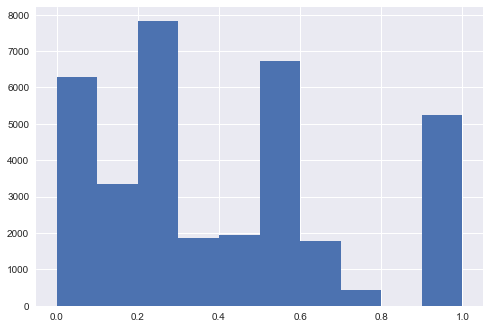

In [170]:
# Clusters:  75
# Mapping Method:  FO

print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
plt.hist(diff.abs().values.flatten())
diff.abs().values.flatten().mean()

Clusters:  75
Mapping Method:  WO


0.4280356296382106

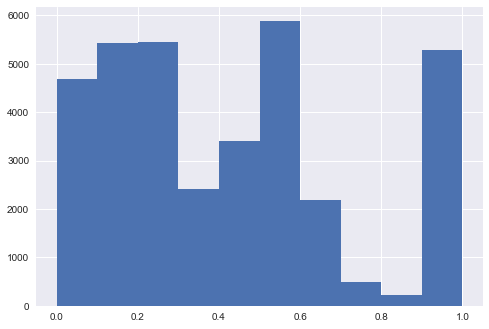

In [172]:
# Clusters:  75
# Mapping Method:  WO
CONFIG["mapping_method"] = 'WO'
print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
plt.hist(diff.abs().values.flatten())

diff.abs().values.flatten().mean()

Clusters:  75
Mapping Method:  FW


0.41001665373508617

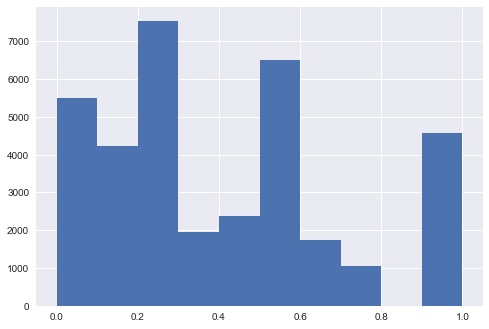

In [173]:
# Clusters:  75
# Mapping Method:  FW
CONFIG["mapping_method"] = 'FW'
print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
plt.hist(diff.abs().values.flatten())

diff.abs().values.flatten().mean()

In [156]:
# Clusters:  20
# Mapping Method:  WO

print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  20
Mapping Method:  FW


0.40332837132271876

In [152]:
# Clusters:  40
# Mapping Method:  WO

print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  40
Mapping Method:  FW


0.40813302614954194

In [147]:
# Clusters:  40
# Mapping Method:  WO

print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  40
Mapping Method:  WO


0.4077944515295144

In [143]:
# Clusters:  20
# Mapping Method:  WO

print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  20
Mapping Method:  WO


0.4106453948359272

In [139]:
#Clusters:  20
# Mapping Method:  FO

print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  20
Mapping Method:  FO


0.41275215585223507

In [133]:
#Clusters:  20
# Mapping Method:  FW
print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  20
Mapping Method:  FW


0.3960831416326906

Old start end dates:

In [122]:
#10 cluster, FW
print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  10
Mapping Method:  FW


0.461676494312892

In [118]:
#40 cluster, FW
print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  40
Mapping Method:  FW


0.4587580147081742

In [114]:
#75 cluster, FW
print('Clusters: ', CONFIG["clusters"])
print('Mapping Method: ', CONFIG["mapping_method"])
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

Clusters:  75
Mapping Method:  FW


0.46788934843651014

In [104]:
#20 cluster, FW
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

0.45492431874973815

In [71]:
#20 cluster, WO
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

0.47809443635440385

In [43]:
#20 cluster, FO
pred = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_predicted_prob.csv')
gt = pd.read_csv(f'outputs/clusters_{CONFIG["clusters"]}_mapping_{CONFIG["mapping_method"]}_gt_prob.csv')

diff = pred[['P(L, N, L)', 'P(H, N, L)']][non_nan] - gt[['P(L, N, L)', 'P(H, N, L)']][non_nan]
diff.abs()
diff.abs().values.flatten().mean()

0.45807210287076255

In [105]:
non_nan = ~(gt[['P(L, N, L)', 'P(H, N, L)']].isna().sum(axis=1).astype(bool))
non_nan.sum(), non_nan.shape


(17738, (52862,))

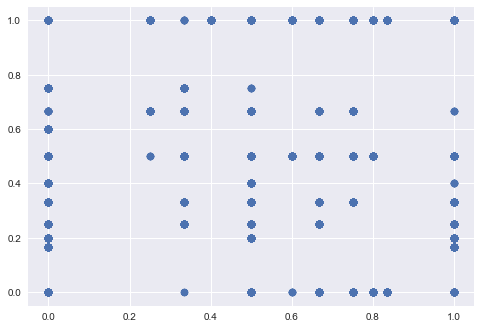

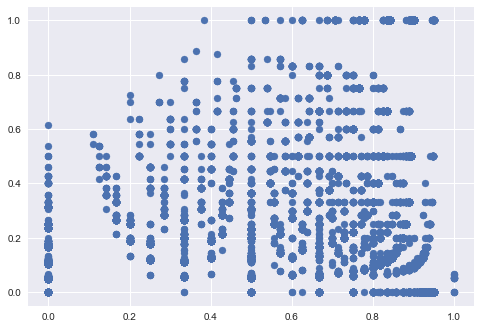

In [192]:
gt_pass = gt[['P(L, N, L)', 'P(H, N, L)']]
pred_pass = pred[['P(L, N, L)', 'P(H, N, L)']]
train_post_warmup_pass = all_transition_probabilities[['P(L, N, L)', 'P(H, N, L)']]
plt.scatter(gt_pass.iloc[:, 0], gt_pass.iloc[:, 1])
plt.show()
# plt.scatter(pred_pass.iloc[:, 0], pred_pass.iloc[:, 1])
# plt.show()
plt.scatter(train_post_warmup_pass.iloc[:, 0], train_post_warmup_pass.iloc[:, 1])

In [ ]:
plt.scatter(gt_pass.iloc[:, 0], gt_pass.iloc[:, 1])